In [1]:
## Import der installierten Module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, \
                            confusion_matrix, \
                            roc_auc_score, \
                            roc_curve, \
                            auc, \
                            accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.tree import plot_tree
from scipy.stats import randint as sp_randint
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
import re
from io import StringIO
import json
import warnings
from joblib import dump, load


C:\Users\Awet\AppData\Local\Temp\ipykernel_42644\11513269.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## Import der eigenen Funktionen

from custom_modules.data_prep import prep_df_dict_format, \
                              get_df_info, \
                              get_df_info_all, \
                              prep_df_format,  \
                              create_age_group,  \
                              extract_names,  \
                              extract_title_group,  \
                              check_cabin_format,  \
                              extract_cabin_level,  \
                              extract_cabin_string_n,  \
                              extract_ticket_string_n
from custom_modules.data_preprocess import imputation_by_median, \
                              imputation_by_mode, \
                              remove_nominal_feature_value
from custom_modules.stats_analysis import print_VIF
from custom_modules.data_viz import categorical_column_distribution, \
                              plot_column_distribution_single, \
                              plot_column_distribution_all, \
                              plot_decision_tree
from custom_modules.model_util import save_model, \
                                        load_model, \
                                        get_accuracy_score, \
                                        get_cm_score, \
                                        get_cr_score, \
                                        get_roc_score, \
                                        get_model_coef_df, \
                                        get_shap_explainer, \
                                        get_shap_importance, \
                                        get_shap_beeswarm, \
                                        get_shap_waterfall_single, \
                                        plot_shap_waterfall_single, \
                                        get_cv_param_scoring


In [3]:
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
# path to the config.json file
config_file_path = 'config.json'

# ppen the config.json file and load its content
with open(config_file_path, 'r') as file:
    config = json.load(file)

input_data_path = config['input_data_dir']
output_data_path = config['output_data_dir']
plot_path = config['plot_dir']
model_path = config['model_dir']
random_state = config['random_state']

In [5]:
# Load Data

df_train = pd.read_csv(input_data_path+'train.csv')
df_test = pd.read_csv(input_data_path+'test.csv')
df_gs = pd.read_csv(input_data_path+'gender_submission.csv')


print(f"Train Data: {df_train.shape}")
print(f"Test Data: {df_test.shape}")
print(f"gender_submission Data: {df_gs.shape}")



Train Data: (891, 12)
Test Data: (418, 11)
gender_submission Data: (418, 2)


In [6]:
df_train.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_test.head(n=5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_gs.head(n=5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### Dataset preparation

In [9]:
df_train_init = df_train.copy() 
df_test_init = df_test.copy() 

dfs_dict = {
            "df_train" : df_train,
            "df_test" : df_test,
            #"df_gs" : df_gs 
            }

dfs_names = list(dfs_dict.keys())

In [10]:
#dfs = [df_train, df_test, df_gs]
for df in dfs_names:
    print(dfs_dict[df].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

In [11]:
get_df_info(dfs_dict["df_train"])

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,PassengerId,891,0,int64,891
1,Survived,891,0,int64,891
2,Pclass,891,0,int64,891
3,Name,891,0,object,891
4,Sex,891,0,object,891
5,Age,714,177,float64,891
6,SibSp,891,0,int64,891
7,Parch,891,0,int64,891
8,Ticket,891,0,object,891
9,Fare,891,0,float64,891


In [12]:
get_df_info_all(dfs_dict)

Non-Null Count          Null Count          Total Count             Dtype         
DataFrame          df_test df_train    df_test df_train     df_test df_train  df_test df_train
Column                                                                                        
Age                    332      714         86      177         418      891  float64  float64
Cabin                   91      204        327      687         418      891   object   object
Embarked               418      889          0        2         418      891   object   object
Fare                   417      891          1        0         418      891  float64  float64
Name                   418      891          0        0         418      891   object   object
Parch                  418      891          0        0         418      891    int64    int64
PassengerId            418      891          0        0         418      891    int64    int64
Pclass                 418      891          0        0         418      891    int64    int64
Sex                    418      891          0        0         418      891   object   object
SibSp                  418      891          0        0         418      891    int64    int64
Survived               NaN      891        NaN        0         NaN      891      NaN    int64
Ticket                 418      891          0        0         418      891   object   object

In [13]:
# Format einzelner Spalten anpassen

int_columns_to_format = ["Survived", "SibSp", "Parch"]
float_columns_to_format = ["Age", "Fare"]
object_columns_to_format = ["Cabin", "Embarked", "Name", "PassengerId", "Pclass", "Sex", "Ticket"]
numeric_columns_to_format = int_columns_to_format + float_columns_to_format

print(f"len_columns: {len(int_columns_to_format)+len(float_columns_to_format)+len(object_columns_to_format)}")

dfs_dict = prep_df_dict_format(dfs_dict)

len_columns: 12
len_columns: 12
Error: Survived in df_test


In [14]:
get_df_info_all(dfs_dict)

Non-Null Count          Null Count          Total Count             Dtype         
DataFrame          df_test df_train    df_test df_train     df_test df_train  df_test df_train
Column                                                                                        
Age                    332      714         86      177         418      891  float64  float64
Cabin                   91      204        327      687         418      891   object   object
Embarked               418      889          0        2         418      891   object   object
Fare                   417      891          1        0         418      891  float64  float64
Name                   418      891          0        0         418      891   object   object
Parch                  418      891          0        0         418      891    Int64    Int64
PassengerId            418      891          0        0         418      891   object   object
Pclass                 418      891          0        0         418      891   object   object
Sex                    418      891          0        0         418      891   object   object
SibSp                  418      891          0        0         418      891    Int64    Int64
Survived               NaN      891        NaN        0         NaN      891      NaN   object
Ticket                 418      891          0        0         418      891   object   object

#### Initial Data Viz für EDA und Hypothesenfindung

#### Variablen und Hypothesen
* survival | Zielgröße
* pclass | Wahrscheinlich wurden Passagiere 1er Klasse Vorrang beim Besetzen von Booten gelassen - Analog 3. Klasse als letztes gerettet.
* sex | Besondern junge/alte Menschen und teilweise Frauen haben es im direkten Kampf zu den Rettungsbooten wahrscheinlich schwerer gehabt. Jedoch, wurde wahrscheinlich Kindern, Alten und Frauen Vorrang beim Besetzen von Booten gelassen.
* Age | Besondern junge/alte Menschen und teilweise Frauen haben es im direkten Kampf zu den Rettungsbooten wahrscheinlich schwerer gehabt. Jedoch, wurde wahrscheinlich Kindern, Alten und Frauen Vorrang beim Besetzen von Booten gelassen.
* sibsp | Mehr Familienmitglieder veringern die "Jeder für sich" Mentalität, die zum frühzeitigen Erreichen eines Rettungsbootes wichtig ist. Mit Kindern/Eltern wird im Chaos des Unfalls wahrscheinlich nicht nur als sich gedacht, was die Überlebenschancen verringern könnte.
* parch | Mehr Familienmitglieder veringern die "Jeder für sich" Mentalität, die zum frühzeitigen Erreichen eines Rettungsbootes wichtig ist. Mit Kindern/Eltern wird im Chaos des Unfalls wahrscheinlich nicht nur als sich gedacht, was die Überlebenschancen verringern könnte.
* ticket | Wahrscheinlich nicht relevant
* fare | Information zum Einkommen/Sozialen Rang (ähnlich wie pclass)
* cabin | KabinenNr -> Möglicherweise Information zur Position des Passagieres an Bord während des Unfalls. Ebenfalls Information zum Einkommen/Sozialen Rang (ähnlich wie pclass)
* embarked | Hafen des an Bord gehens:	C = Cherbourg, Q = Queenstown, S = Southampton

In [15]:
df_train["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

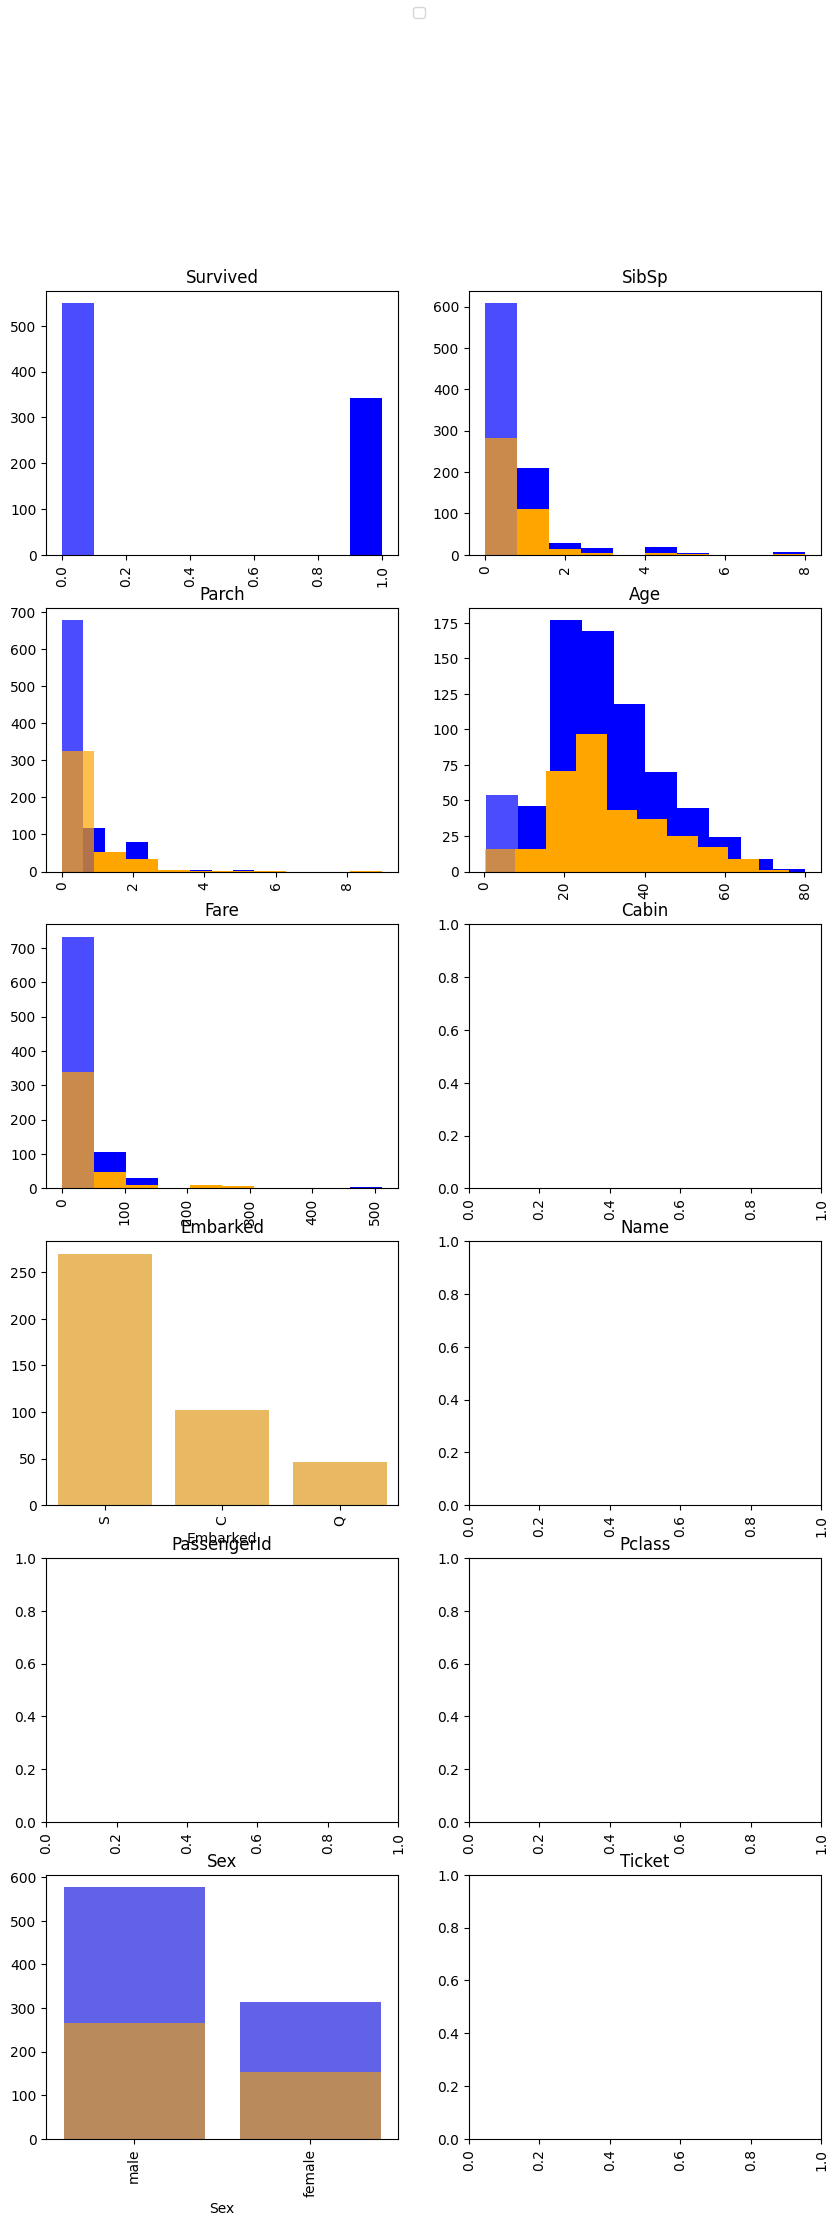

In [16]:
### TRAIN/TEST absolute column distribution

plot_column_distribution_all(df_1=df_train_init, 
                             df_2=df_test_init, 
                             cat_cols=object_columns_to_format, 
                             num_cols=numeric_columns_to_format, 
                             density=False, 
                             target=False,
                             dropna=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

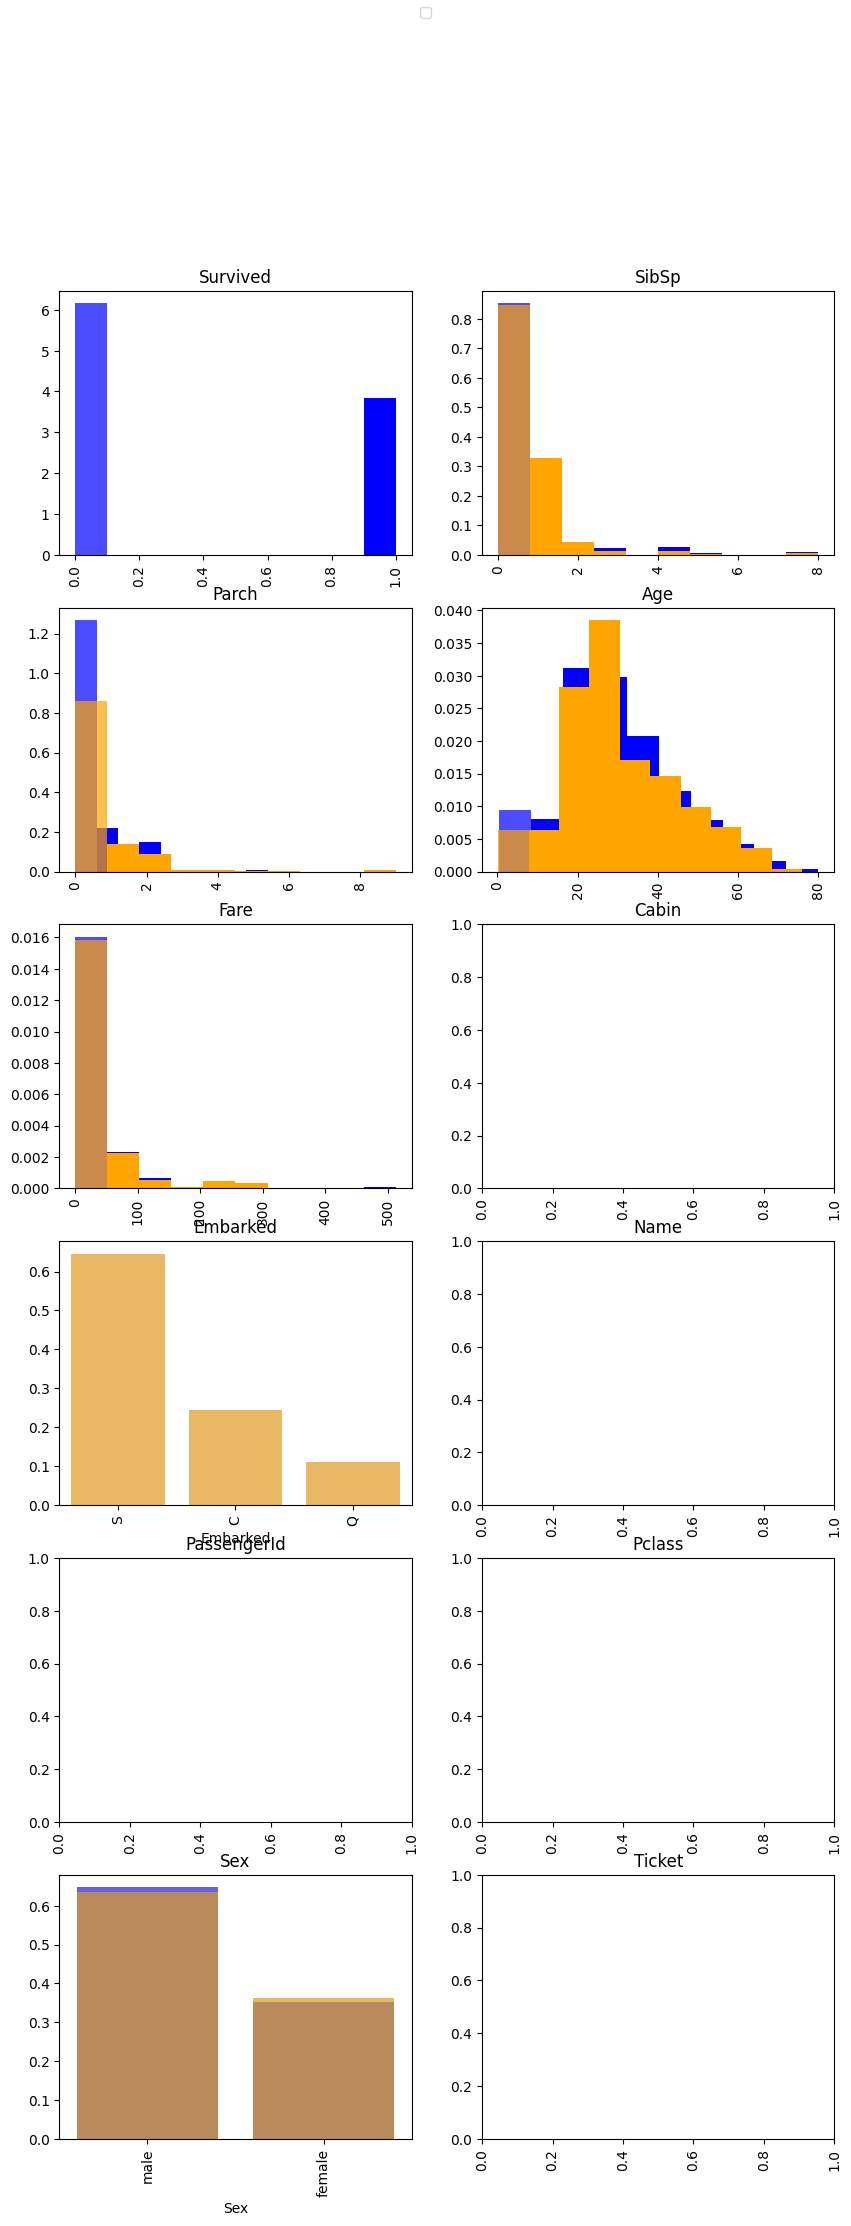

In [17]:
### TRAIN/TEST relative column distribution

plot_column_distribution_all(df_1=df_train_init, 
                             df_2=df_test_init, 
                             cat_cols=object_columns_to_format, 
                             num_cols=numeric_columns_to_format, 
                             density=True, 
                             target=False,
                             dropna=False)

In [18]:
df_train_pos = df_train_init[df_train_init.Survived == 1].copy()
df_train_neg = df_train_init[df_train_init.Survived == 0].copy()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

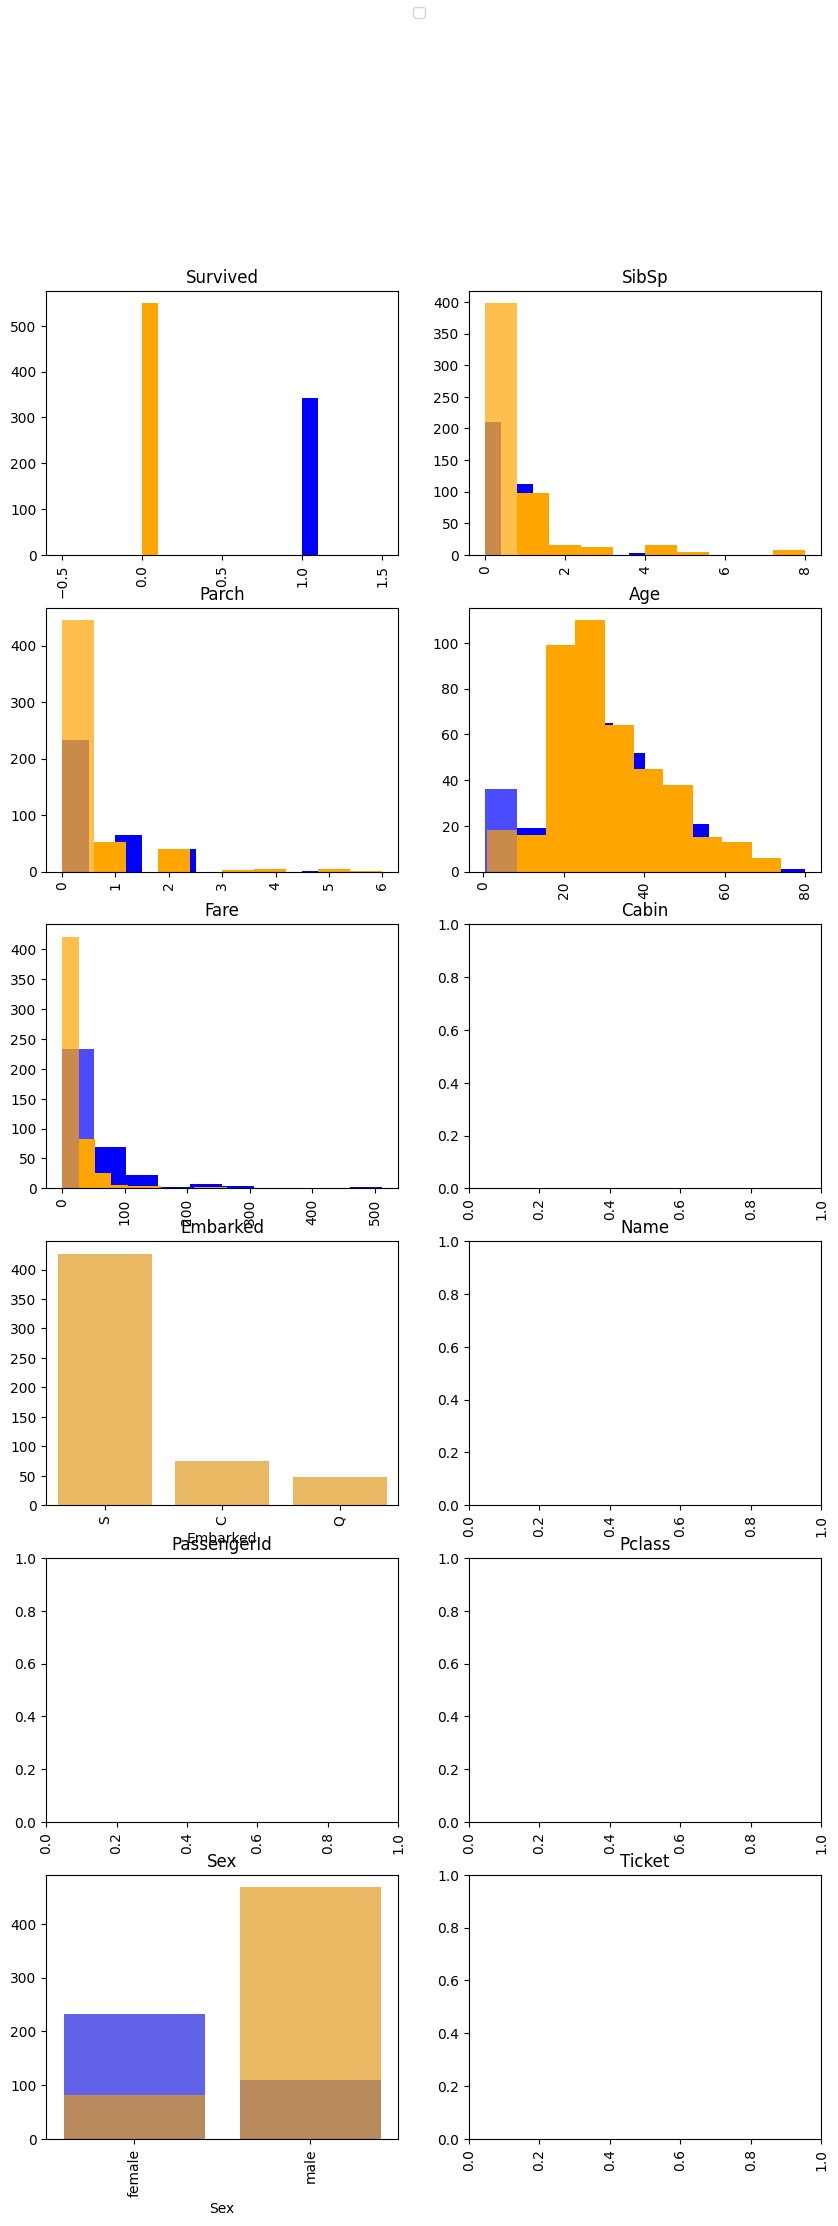

In [19]:
### TARGET absolute column distribution

plot_column_distribution_all(df_1=df_train_pos, 
                             df_2=df_train_neg, 
                             cat_cols=object_columns_to_format, 
                             num_cols=numeric_columns_to_format, 
                             density=False, 
                             target=True,
                             dropna=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

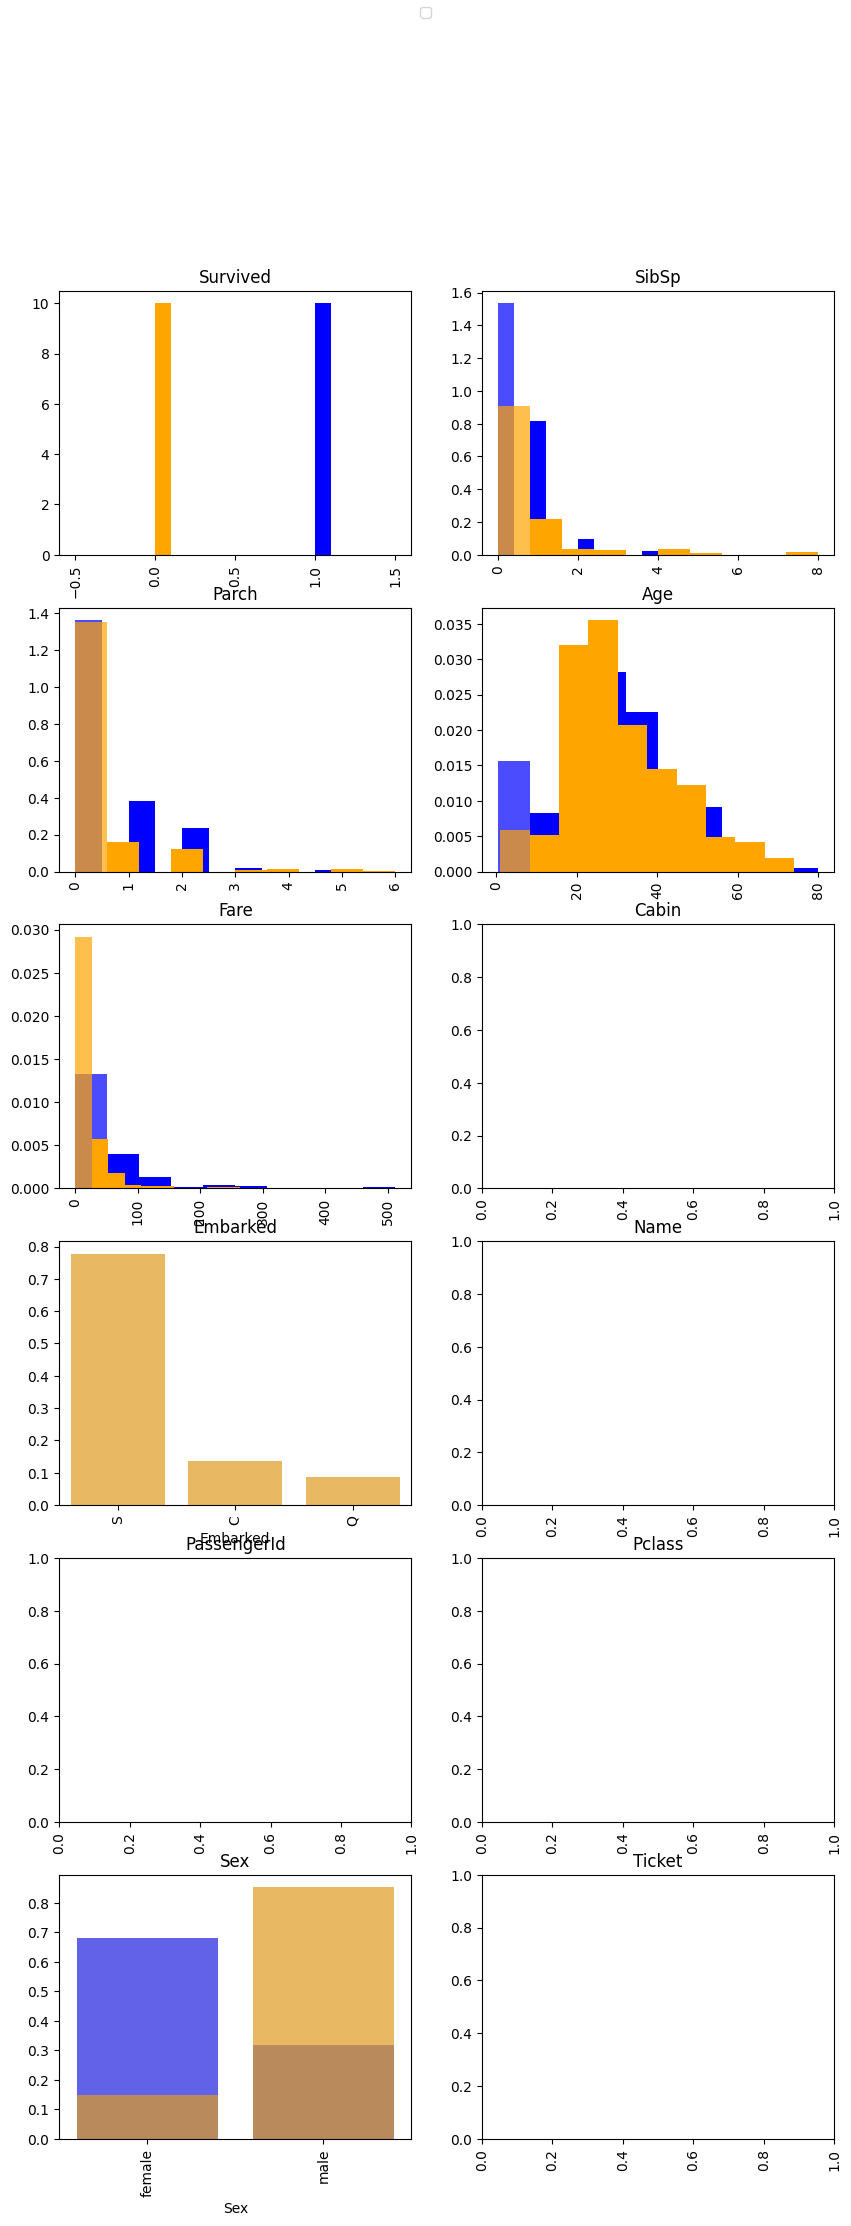

In [20]:
### TARGET relative column distribution

plot_column_distribution_all(df_1=df_train_pos, 
                             df_2=df_train_neg, 
                             cat_cols=object_columns_to_format, 
                             num_cols=numeric_columns_to_format, 
                             density=True, 
                             target=True,
                             dropna=False)

### Einzelne Features näher Untersuchen und ggf. ergänzen

#### Wichtige Anmerkung!

In normalen Usecases für Klassifizierungs/Prognosemodellen auf Basis von Personendaten, würden die Features "Gender/Sex" und "Age" nicht verwendet, um diskriminierendes Verhalten des Models zu vehindern.
* Zum Bewerten der Performance würden Alter und Geschlecht wieder herangezogen, um die Vorhersagekraft des Models für verschiedene Untergruppen zu überprüfen

**Da dieser Usercase zu Demonstrationszwecken und nicht die operative Verwendung gedacht iist, werden Gender und Age hier verwendet**

In [21]:
print(df_train.columns.tolist())

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']


#### Gender

df_pos: (342, 12), df_neg: (549, 12)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

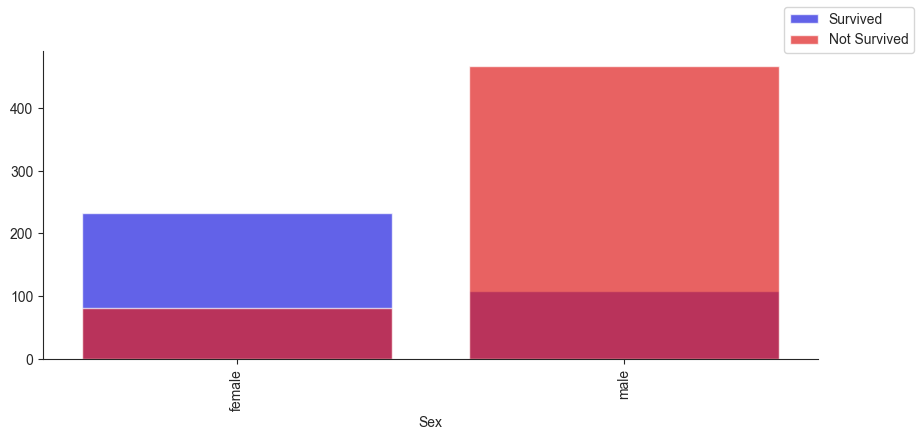

In [22]:
plot_column_distribution_single(df_train, "Sex", target=True, density=False)

df_pos: (342, 12), df_neg: (549, 12)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

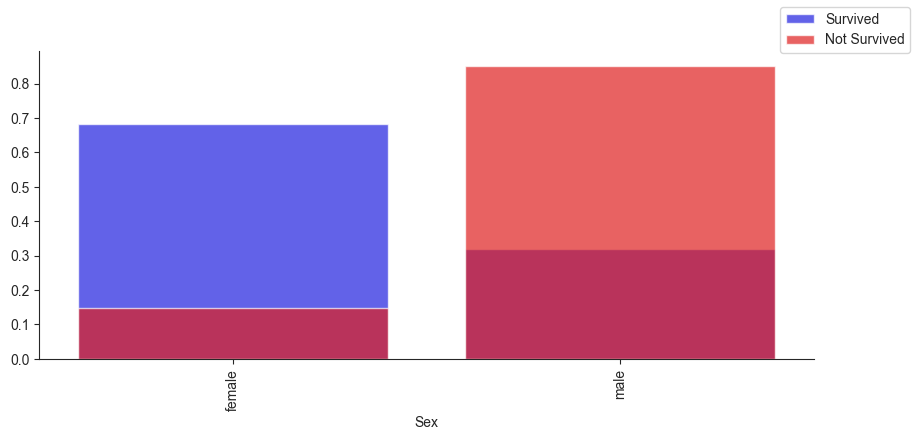

In [23]:
plot_column_distribution_single(df_train, "Sex", target=True)

#### Age

df_pos: (342, 12), df_neg: (549, 12)
df_pos: float64, df_neg: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

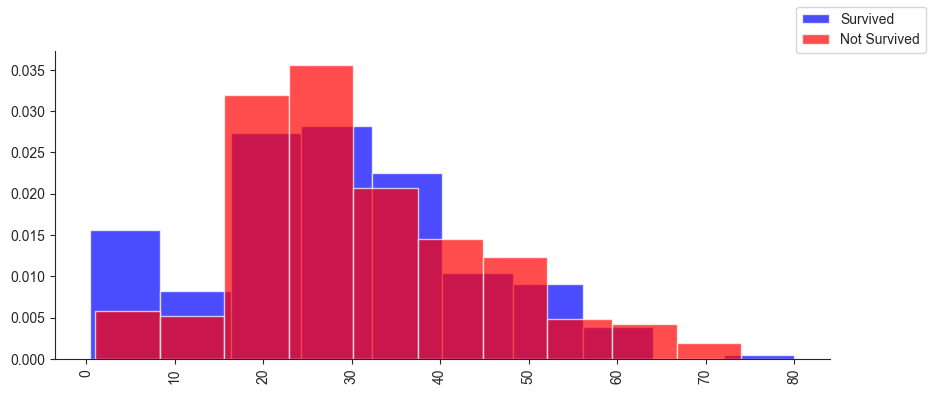

In [24]:
plot_column_distribution_single(df_train, "Age", target=True)

In [25]:
df_train_m = df_train[df_train["Sex"]=="male"].copy()
df_train_f = df_train[df_train["Sex"]=="female"].copy()

print(f"df_train: {df_train.shape}")
print(f"df_train_m: {df_train_m.shape}, df_train_f: {df_train_f.shape}")

df_train: (891, 12)
df_train_m: (577, 12), df_train_f: (314, 12)


In [26]:
df_train_m = create_age_group(df_train_m)
df_train_f = create_age_group(df_train_f)
df_train_m['age_group'] = df_train_m['age_group'].astype('object')
df_train_f['age_group'] = df_train_f['age_group'].astype('object')

print(f"df_train_m: {df_train_m.shape}, df_train_f: {df_train_f.shape}")

df_train_m: (577, 13), df_train_f: (314, 13)


In [27]:
df_train_m['age_group'].value_counts()

age_group
Young Adults    193
Adults          183
Baby             23
Teenager         21
Senior           19
Child            14
Name: count, dtype: int64

df_pos: (109, 13), df_neg: (468, 13)
df_pos: float64, df_neg: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

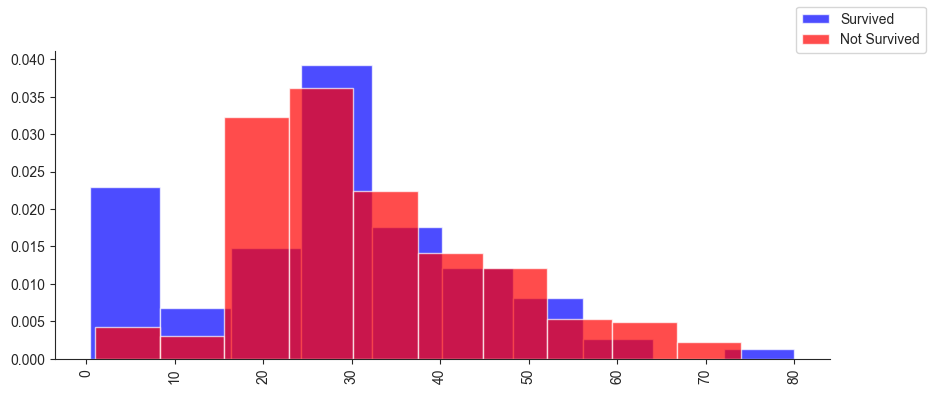

In [28]:
plot_column_distribution_single(df_train_m, "Age", target=True)

df_pos: (233, 13), df_neg: (81, 13)
df_pos: float64, df_neg: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

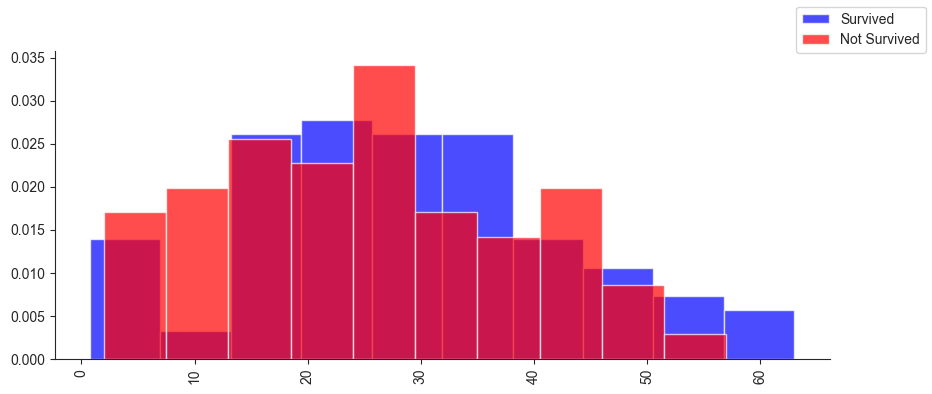

In [29]:
plot_column_distribution_single(df_train_f, "Age", target=True)

df_pos: (109, 13), df_neg: (468, 13)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

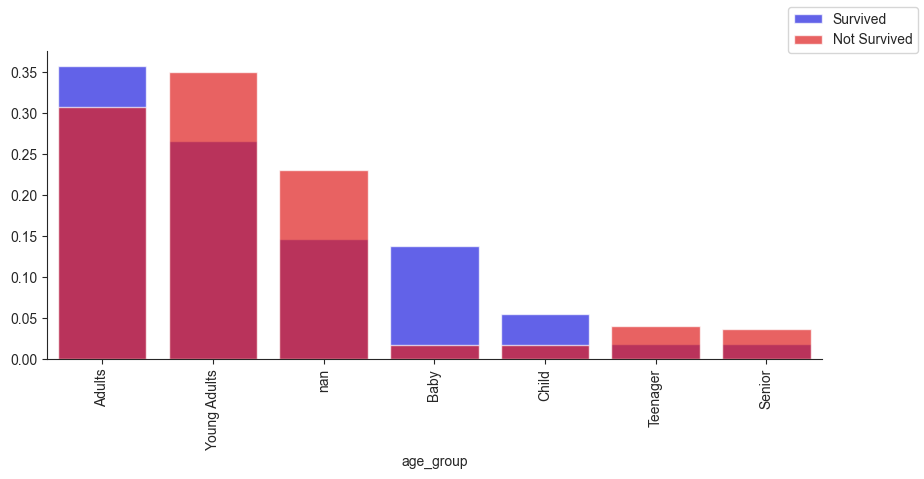

In [30]:
plot_column_distribution_single(df_train_m, "age_group", target=True)

df_pos: (233, 13), df_neg: (81, 13)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

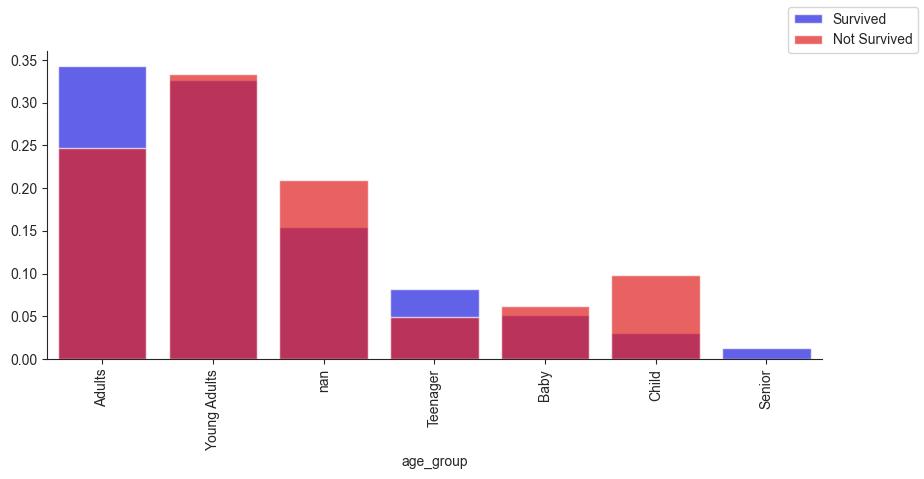

In [31]:
plot_column_distribution_single(df_train_f, "age_group", target=True)

#### Family (Parch & SibSp)

df_pos: (342, 12), df_neg: (549, 12)
df_pos: Int64, df_neg: Int64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

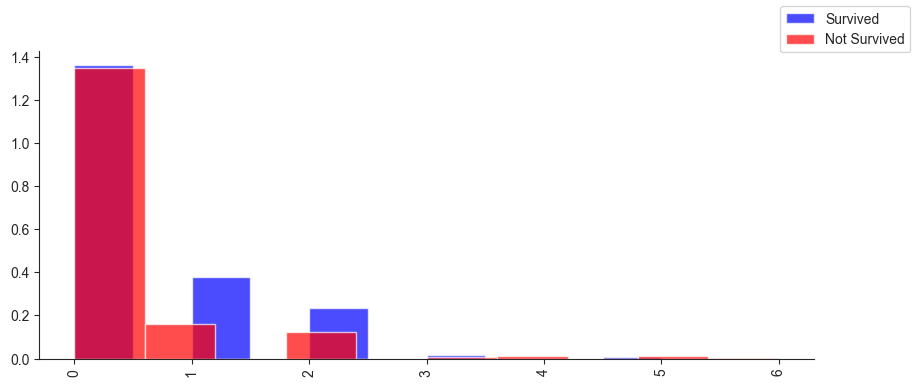

In [32]:
plot_column_distribution_single(df_train, "Parch", target=True)

df_pos: (342, 12), df_neg: (549, 12)
df_pos: Int64, df_neg: Int64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

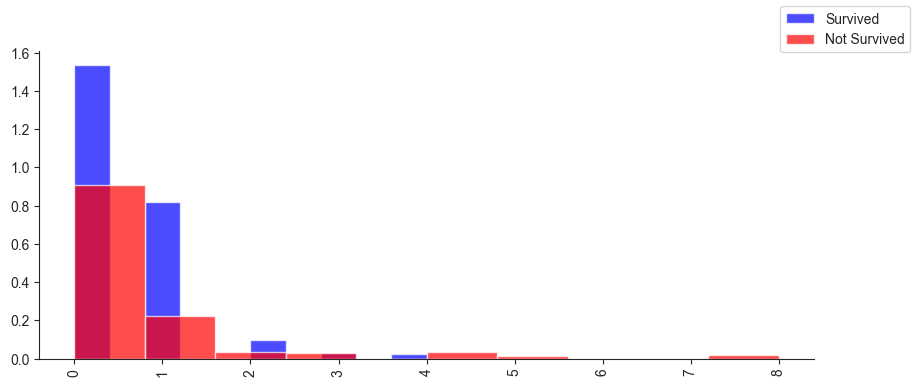

In [33]:
plot_column_distribution_single(df_train, "SibSp", target=True)

#### Name (Familienbeziehungen, Sozialen Rang etc. )

In [34]:
# Vorname, Titel, Nachname
df_train['Lastname'] = df_train['Name'].str.split(',', expand=True)[0].str.strip()
df_train['Title'] = df_train['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()
df_train['Firstname'] = df_train['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[1].str.strip()

df_train.shape


(891, 15)

In [35]:
df_train.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


In [36]:
len(df_train["Lastname"].unique())

667

In [37]:
df_train["Title"].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [38]:
### Firstname, Name und Lastname sind nicht weiter relevant für die Vorhersage
cols_2_drop = ["Firstname", "Name", "Lastname"]

## passe Title so an, dass kleinere Gruppen zusammengefasst werden
df_train["Title"].value_counts().keys()

Index(['Mr', 'Miss', 'Mrs', 'Master', 'Dr', 'Rev', 'Mlle', 'Major', 'Col', 'the Countess', 'Capt', 'Ms', 'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer'], dtype='object', name='Title')

In [39]:
df_train = extract_title_group(df_train)

df_train["Title_group"].value_counts()

Title_group
Civilian    868
MediReli     13
Noble         5
Military      5
Name: count, dtype: int64

In [40]:
df_train[df_train["Title_group"]=="Civilian"]["Survived"].value_counts()

Survived
0    534
1    334
Name: count, dtype: int64

df_pos: (342, 16), df_neg: (549, 16)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

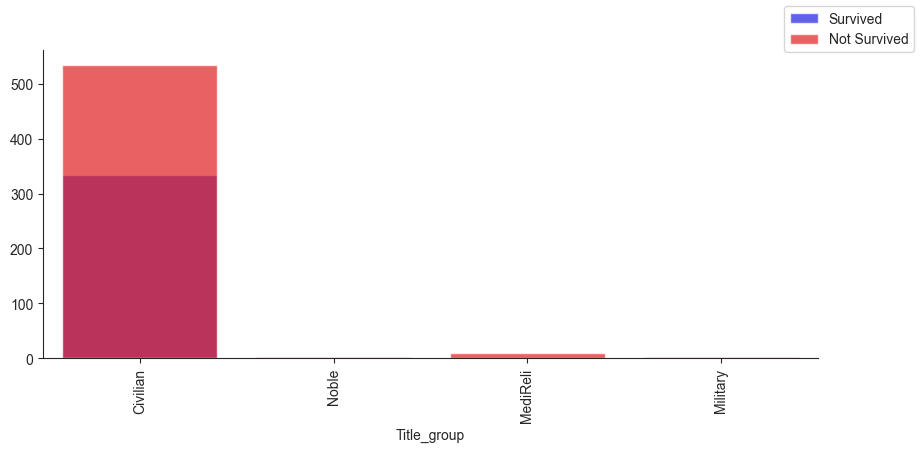

In [41]:
plot_column_distribution_single(df_train, "Title_group", target=True, density=False)

df_pos: (342, 16), df_neg: (549, 16)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

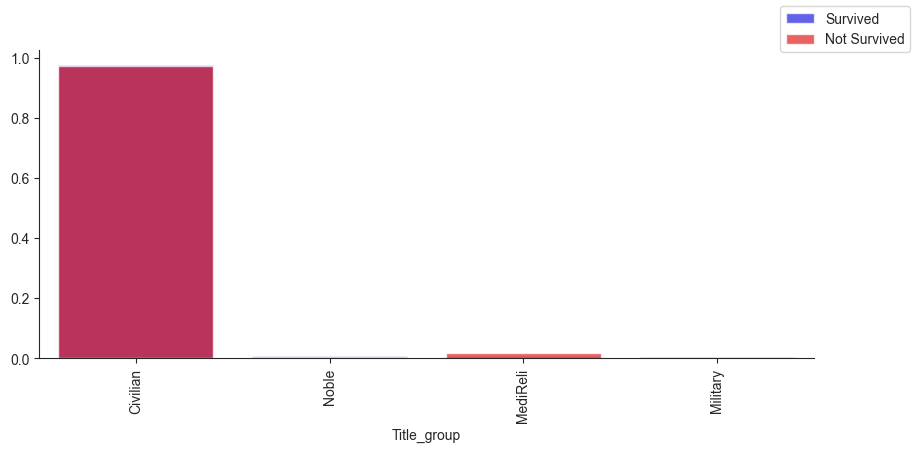

In [42]:
plot_column_distribution_single(df_train, "Title_group", target=True)

#### Cabin (Position der Person in der Titanic ableiten)

In [43]:
# Cabin und Ticket näher untersuchen

df_train["Cabin"].value_counts()

Cabin
B96 B98            4
G6                 4
C23 C25 C27        4
C22 C26            3
F33                3
F2                 3
E101               3
D                  3
C78                2
C93                2
E8                 2
D36                2
B77                2
C123               2
E121               2
E44                2
D35                2
C125               2
E67                2
B35                2
B18                2
E24                2
B49                2
C65                2
B20                2
B5                 2
B57 B59 B63 B66    2
C126               2
B51 B53 B55        2
F4                 2
C124               2
F G73              2
B58 B60            2
C52                2
D33                2
C68                2
D20                2
D26                2
B28                2
C83                2
E25                2
D17                2
B22                2
C92                2
C2                 2
E33                2
C70                1
E58    

In [44]:
df_train['Cabin_Format'] = check_cabin_format(df_train)

df_train["Cabin_Format"].value_counts()

Cabin_Format
False    687
True     204
Name: count, dtype: int64

In [45]:
#df_train.loc[df_train['Cabin_Format'], 'Cabin_Level'] = df_train.loc[df_train['Cabin_Format'], 'Cabin'].str[0]
df_train = extract_cabin_level(df_train)


In [46]:
df_train.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,Civilian,False,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Civilian,True,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,Civilian,False,NaN


In [47]:
df_train["Cabin_Level"].value_counts(dropna=False)#.sum()

Cabin_Level
NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: count, dtype: int64

df_pos: (342, 18), df_neg: (549, 18)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

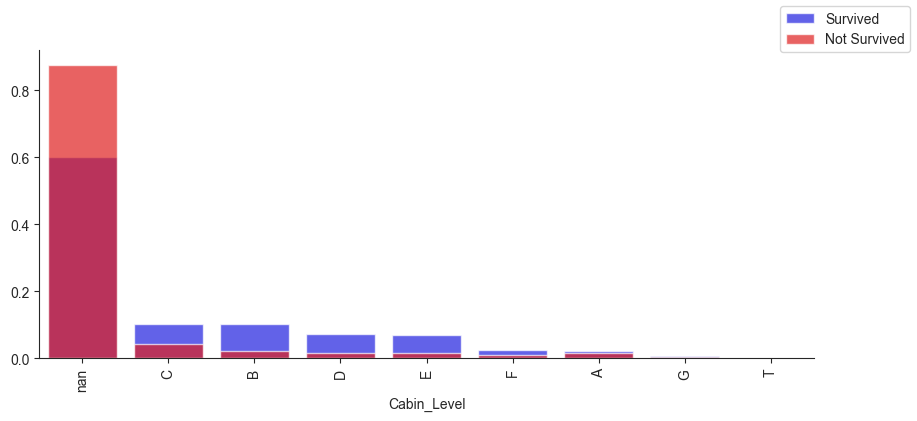

In [48]:
plot_column_distribution_single(df_train, "Cabin_Level")

df_pos: (342, 18), df_neg: (549, 18)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

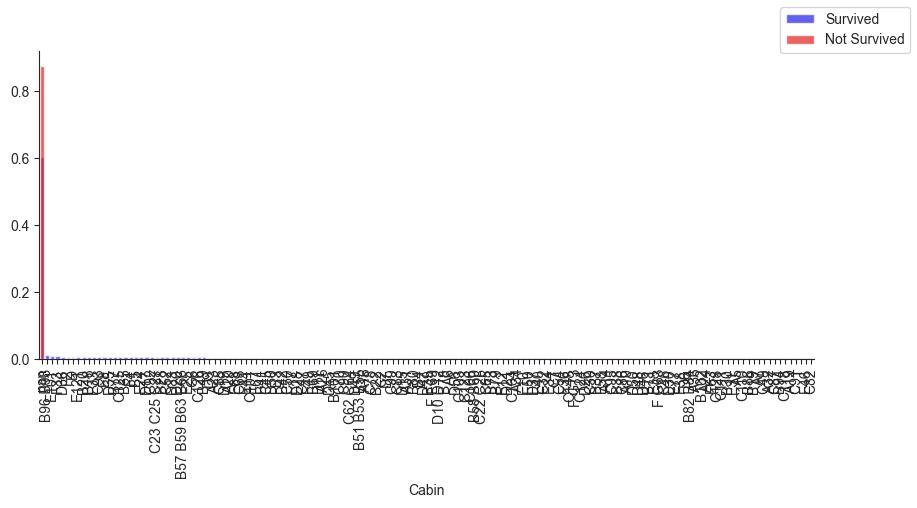

In [49]:
plot_column_distribution_single(df_train, "Cabin")

In [50]:
## Länge der CabinStrings
df_train = extract_cabin_string_n(df_train)

In [51]:
df_train["Cabin_String_N"].value_counts(dropna=False)

Cabin_String_N
NaN     687
3.0     128
4.0      24
2.0      24
7.0      12
11.0      6
5.0       4
1.0       4
15.0      2
Name: count, dtype: int64

<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

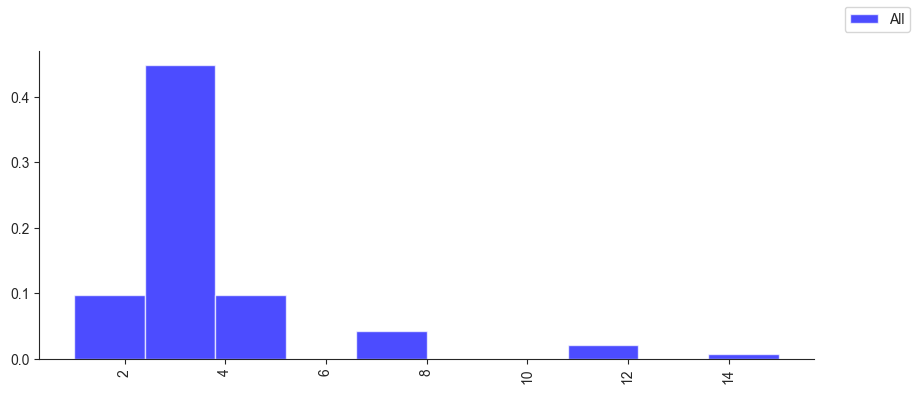

In [52]:
plot_column_distribution_single(df_train, "Cabin_String_N", target=False)

In [53]:
df_train["Cabin_String_3"].value_counts(dropna=False)

Cabin_String_3
NaN    687
1      128
0       76
Name: count, dtype: int64

df_pos: (342, 20), df_neg: (549, 20)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

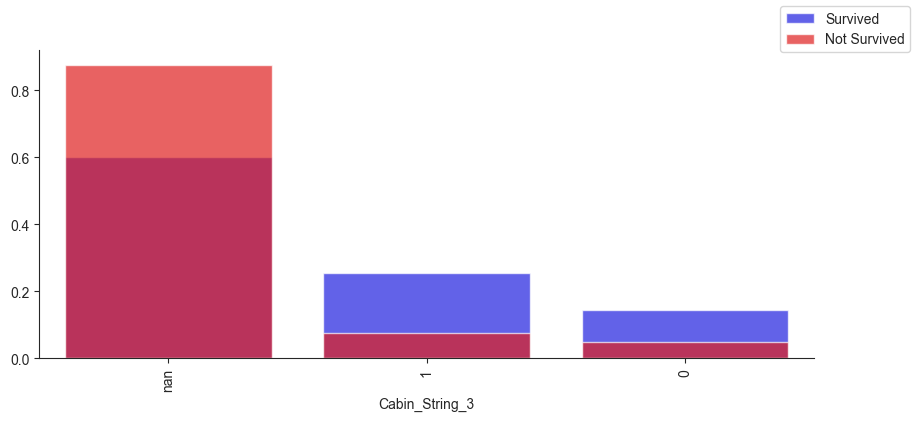

In [54]:
plot_column_distribution_single(df_train, "Cabin_String_3", target=True)

#### Ticket

In [55]:
print(df_train.shape)
df_train.head(n=2)

(891, 20)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level,Cabin_String_N,Cabin_String_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,Civilian,False,NaN,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Civilian,True,C,3.0,1


In [56]:
df_train["Ticket"].value_counts(dropna=False)#.sum()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [57]:
df_train[df_train["Ticket"] == "347082"] # 7 Personen mit gleichem Ticketnr, Fare und Nachnamen (Familie)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level,Cabin_String_N,Cabin_String_3
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S,Andersson,Mr,Anders Johan,Civilian,False,NaN,NaN,NaN
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S,Andersson,Miss,Ellis Anna Maria,Civilian,False,NaN,NaN,NaN
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S,Andersson,Miss,Ingeborg Constanzia,Civilian,False,NaN,NaN,NaN
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S,Andersson,Miss,Sigrid Elisabeth,Civilian,False,NaN,NaN,NaN
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S,Andersson,Mrs,Anders Johan (Alfrida Konstantia Brogren),Civilian,False,NaN,NaN,NaN
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S,Andersson,Miss,Ebba Iris Alfrida,Civilian,False,NaN,NaN,NaN
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S,Andersson,Master,Sigvard Harald Elias,Civilian,False,NaN,NaN,NaN


In [58]:
df_train[df_train["Ticket"] == "1601"] # 7 Personen mit gleichem Ticketnr, Fare aber unterschiedlichen Nachnamen (keine Familie)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level,Cabin_String_N,Cabin_String_3
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S,Bing,Mr,Lee,Civilian,False,NaN,NaN,NaN
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S,Ling,Mr,Lee,Civilian,False,NaN,NaN,NaN
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,Lang,Mr,Fang,Civilian,False,NaN,NaN,NaN
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S,Foo,Mr,Choong,Civilian,False,NaN,NaN,NaN
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,Lam,Mr,Ali,Civilian,False,NaN,NaN,NaN
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,Lam,Mr,Len,Civilian,False,NaN,NaN,NaN
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S,Chip,Mr,Chang,Civilian,False,NaN,NaN,NaN


In [59]:
## Spalte Ticket mit Ticket_6 (6 Zeichen) erstellen (Binär)
print(df_train.shape)
#df_train['Ticket_String_6'] = df_train['Ticket'].apply(lambda x: "1" if len(str(x)) == 6 and str(x).isdigit() else "0")
df_train = extract_ticket_string_n(df_train)
print(df_train.shape)

(891, 20)
(891, 21)


In [60]:
df_train.head(n=3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level,Cabin_String_N,Cabin_String_3,Ticket_String_6
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris,Civilian,False,NaN,NaN,NaN,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer),Civilian,True,C,3.0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina,Civilian,False,NaN,NaN,NaN,0


df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

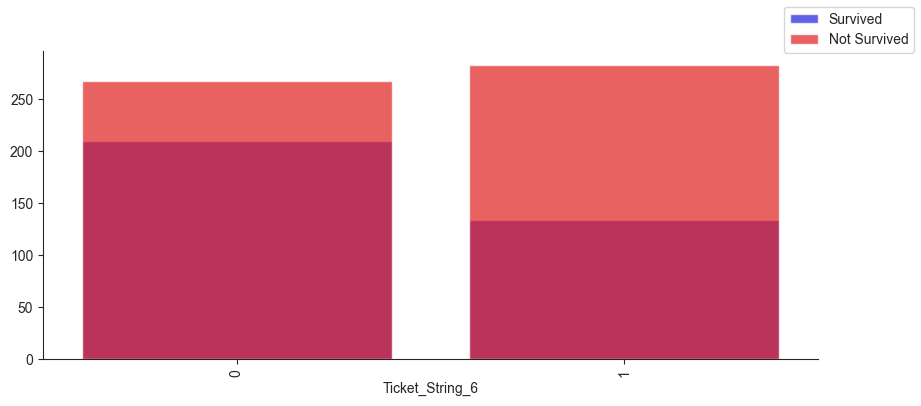

In [61]:
plot_column_distribution_single(df_train, "Ticket_String_6", target=True, density=False)

df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

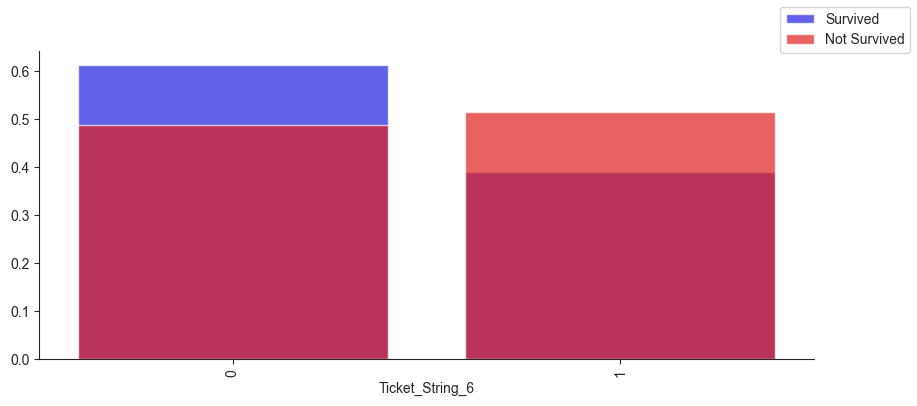

In [62]:
plot_column_distribution_single(df_train, "Ticket_String_6", target=True)

#### Pclass

In [63]:
### Pclass prüfen

df_train['Pclass'].value_counts(dropna=False)

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [64]:
df_train[df_train['Ticket_String_6'] == "1"]['Pclass'].value_counts(dropna=False)

Pclass
3    256
2     87
1     72
Name: count, dtype: int64

In [65]:
df_train[df_train['Ticket_String_6'] == "0"]['Pclass'].value_counts(dropna=False)

Pclass
3    235
1    144
2     97
Name: count, dtype: int64

df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

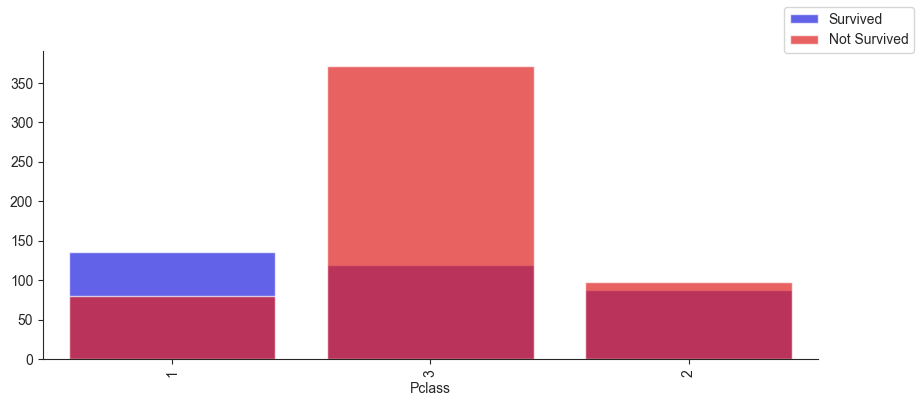

In [66]:
plot_column_distribution_single(df_train, "Pclass", target=True, density=False)

df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

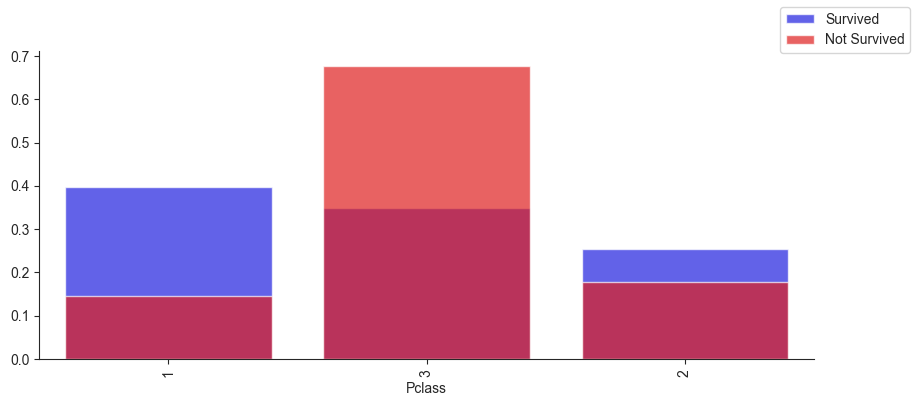

In [67]:
plot_column_distribution_single(df_train, "Pclass", target=True)

#### Fare (Passenger fare)

In [68]:
df_train['Fare'].value_counts(dropna=False)

Fare
8.0500      43
13.0000     42
7.8958      38
7.7500      34
26.0000     31
10.5000     24
7.9250      18
7.7750      16
7.2292      15
0.0000      15
26.5500     15
7.8542      13
8.6625      13
7.2500      13
7.2250      12
9.5000       9
16.1000      9
24.1500      8
15.5000      8
14.4542      7
69.5500      7
52.0000      7
7.0500       7
56.4958      7
14.5000      7
31.2750      7
39.6875      6
7.7958       6
27.9000      6
30.0000      6
46.9000      6
26.2500      6
21.0000      6
27.7208      5
29.1250      5
15.2458      5
73.5000      5
30.5000      5
53.1000      5
39.0000      4
90.0000      4
15.8500      4
13.5000      4
7.5500       4
23.0000      4
12.4750      4
25.4667      4
7.1250       4
7.6500       4
21.0750      4
7.7333       4
11.5000      4
34.3750      4
7.8792       4
19.2583      4
227.5250     4
27.7500      4
263.0000     4
31.3875      4
79.2000      4
151.5500     4
35.5000      4
120.0000     4
110.8833     4
7.4958       3
83.1583      3
211.3

df_pos: (342, 21), df_neg: (549, 21)
df_pos: float64, df_neg: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

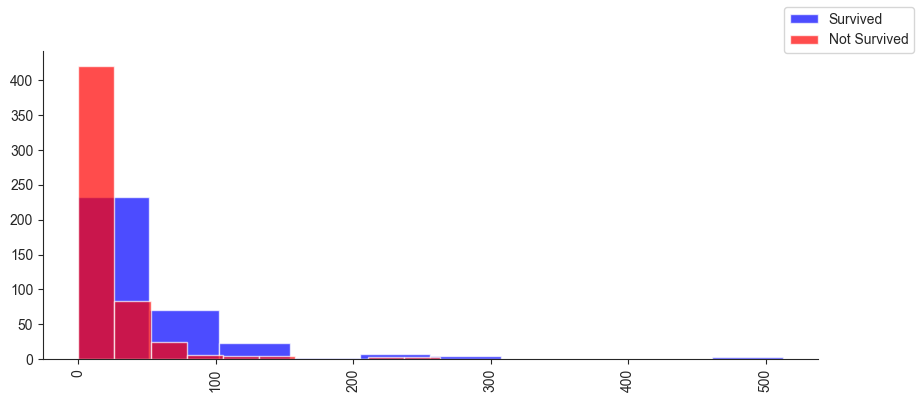

In [69]:
plot_column_distribution_single(df_train, "Fare", target=True, density=False)

df_pos: (342, 21), df_neg: (549, 21)
df_pos: float64, df_neg: float64


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

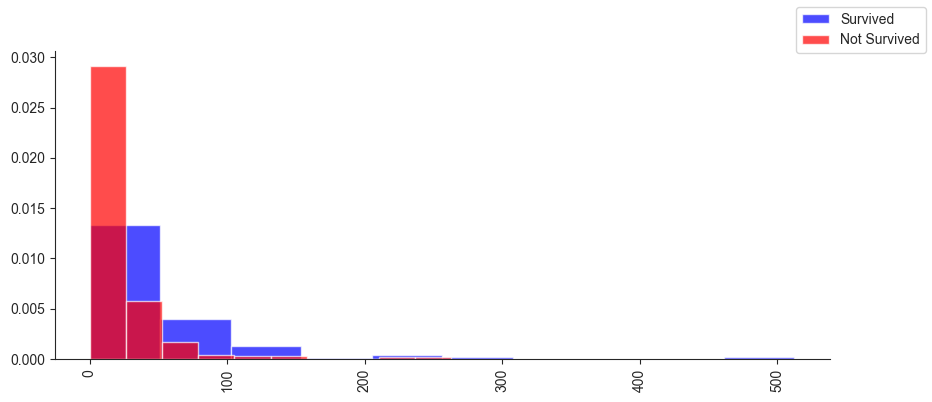

In [70]:
plot_column_distribution_single(df_train, "Fare", target=True)

#### Embarked

df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

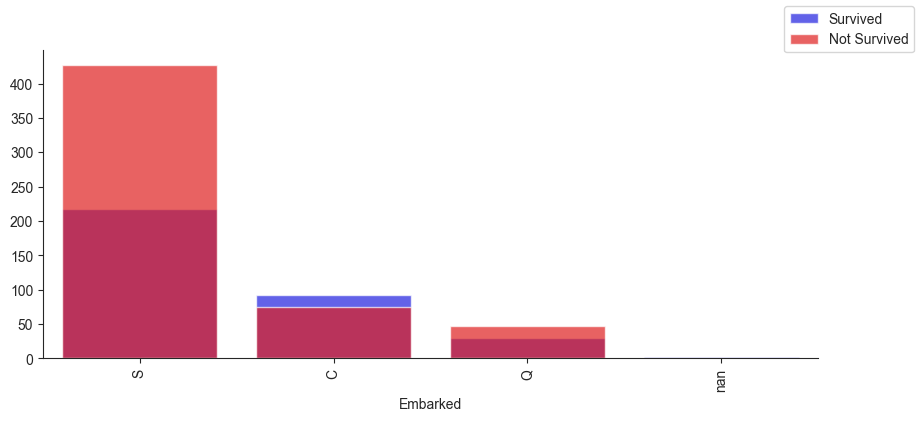

In [71]:
plot_column_distribution_single(df_train, "Embarked", target=True, density=False)

df_pos: (342, 21), df_neg: (549, 21)
df_pos: object, df_neg: object


<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

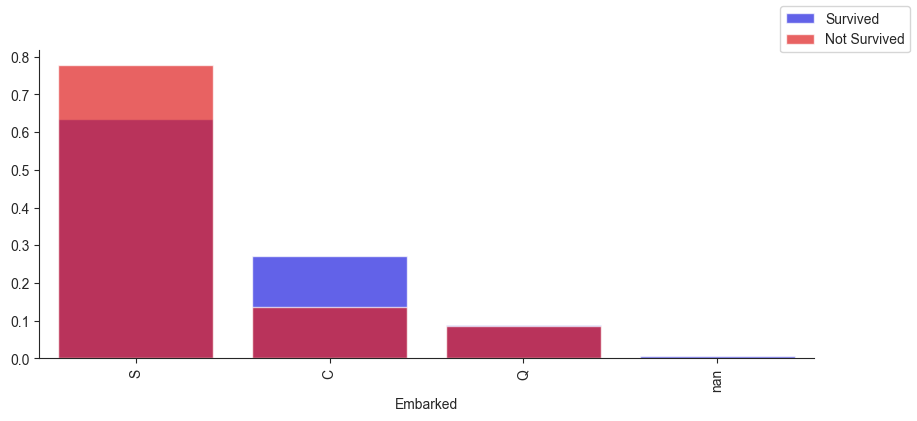

In [72]:
plot_column_distribution_single(df_train, "Embarked", target=True)

## Define X & y 

In [73]:
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [74]:
print(numerical_cols)
rel_num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
print(rel_num_cols)

['Age', 'SibSp', 'Parch', 'Fare', 'Cabin_String_N']
['Age', 'SibSp', 'Parch', 'Fare']


In [75]:
print(categorical_cols)
rel_cat_cols = ['Pclass', 'Sex', 'Embarked', 'Title_group', 'Cabin_Level', 'Cabin_String_3', 'Ticket_String_6']
print(rel_cat_cols)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Lastname', 'Title', 'Firstname', 'Title_group', 'Cabin_Level', 'Cabin_String_3', 'Ticket_String_6']
['Pclass', 'Sex', 'Embarked', 'Title_group', 'Cabin_Level', 'Cabin_String_3', 'Ticket_String_6']


In [76]:
rel_cols = rel_num_cols + rel_cat_cols
rel_cols

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'Pclass',
 'Sex',
 'Embarked',
 'Title_group',
 'Cabin_Level',
 'Cabin_String_3',
 'Ticket_String_6']

In [77]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Lastname', 'Title', 'Firstname', 'Title_group', 'Cabin_Format', 'Cabin_Level', 'Cabin_String_N', 'Cabin_String_3', 'Ticket_String_6'], dtype='object')

In [78]:
df_train.shape

(891, 21)

In [79]:
## prepare testdata wie traindata
## extract_names, extract_title_group, check_cabin_format, extract_cabin_level, extract_cabin_string_n, extract_ticket_string_n
print(df_test.shape)

(418, 11)


In [80]:
X_test = df_test.copy()
X_test = prep_df_format(X_test)
X_test = extract_names(X_test)
X_test = extract_title_group(X_test)
X_test = extract_cabin_level(X_test)
X_test = extract_cabin_string_n(X_test)
X_test = extract_ticket_string_n(X_test)
print(X_test.shape)

len_columns: 12
Error: Survived in object_columns_to_format
(418, 20)


In [81]:
X_test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Lastname', 'Title', 'Firstname', 'Title_group', 'Cabin_Format', 'Cabin_Level', 'Cabin_String_N', 'Cabin_String_3', 'Ticket_String_6'], dtype='object')

In [82]:
get_df_info(X_test)

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,PassengerId,418,0,object,418
1,Pclass,418,0,object,418
2,Name,418,0,object,418
3,Sex,418,0,object,418
4,Age,332,86,float64,418
5,SibSp,418,0,Int64,418
6,Parch,418,0,Int64,418
7,Ticket,418,0,object,418
8,Fare,417,1,float64,418
9,Cabin,91,327,object,418


In [83]:
X_test[X_test["Fare"].isna()]#.shape

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Lastname,Title,Firstname,Title_group,Cabin_Format,Cabin_Level,Cabin_String_N,Cabin_String_3,Ticket_String_6
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Storey,Mr,Thomas,Civilian,False,NaN,NaN,NaN,0


In [84]:
## Define IDs, y and drop columns that are not needed

label_encoder = LabelEncoder()

ids_train = df_train["PassengerId"]
y_train = df_train["Survived"].astype("object")
y_train = label_encoder.fit_transform(y_train)
X_train = df_train[rel_cols]

ids_test = df_gs["PassengerId"]
y_test = df_gs["Survived"].astype("object")
y_test = label_encoder.transform(y_test)
X_test = X_test[rel_cols]

print(f"id_train: {ids_train.shape}, y_train: {y_train.shape}, X_train: {X_train.shape}")
print(f"id_test: {ids_test.shape}, y_test: {y_test.shape}, X_test: {X_test.shape}")


id_train: (891,), y_train: (891,), X_train: (891, 11)
id_test: (418,), y_test: (418,), X_test: (418, 11)


In [85]:
print("Unique target values:", np.unique(y_train))
print("y_train type:", y_train.dtype)
print(f"y_train value counts: {np.unique(y_train, return_counts=True)}")
print(f"y_train value counts %: {np.unique(y_train, return_counts=True)[1]/len(y_train)*100}")

Unique target values: [0 1]
y_train type: int32
y_train value counts: (array([0, 1]), array([549, 342], dtype=int64))
y_train value counts %: [61.61616162 38.38383838]


In [86]:
print("Unique target values:", np.unique(y_test))
print("y_test type:", y_test.dtype)
print(f"y_test value counts: {np.unique(y_test, return_counts=True)}")
print(f"y_test value counts %: {np.unique(y_test, return_counts=True)[1]/len(y_test)*100}")

Unique target values: [0 1]
y_test type: int32
y_test value counts: (array([0, 1]), array([266, 152], dtype=int64))
y_test value counts %: [63.63636364 36.36363636]


In [87]:
y_train.dtype, y_test.dtype

(dtype('int32'), dtype('int32'))

In [88]:
save_model(label_encoder, "label_encoder", model_path)

Model saved as models/label_encoder.joblib


In [89]:
get_df_info(X_train)

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,Age,714,177,float64,891
1,SibSp,891,0,Int64,891
2,Parch,891,0,Int64,891
3,Fare,891,0,float64,891
4,Pclass,891,0,object,891
5,Sex,891,0,object,891
6,Embarked,889,2,object,891
7,Title_group,891,0,object,891
8,Cabin_Level,204,687,object,891
9,Cabin_String_3,204,687,object,891


In [90]:
get_df_info(X_test)

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,Age,332,86,float64,418
1,SibSp,418,0,Int64,418
2,Parch,418,0,Int64,418
3,Fare,417,1,float64,418
4,Pclass,418,0,object,418
5,Sex,418,0,object,418
6,Embarked,418,0,object,418
7,Title_group,418,0,object,418
8,Cabin_Level,91,327,object,418
9,Cabin_String_3,91,327,object,418


In [91]:
## Daten bereits gesplittet, daher keine weitere Aufteilung notwendig
## Validation Set wird aus Trainingsdaten erstellt während des Trainings

## Imputation, Scaling und Encoding

#### Imputation von fehlenden Werten

In [92]:
# Befülle NA Werte relativ zur Pclass (Annahme ist, das Passagiere der ersten Klasse andere Werte haben als Passagiere der dritten Klasse)

X_train["Age"] = imputation_by_median(X_train, "Age", "Pclass")
X_test["Age"] = imputation_by_median(X_test, "Age", "Pclass")

X_train["Fare"] = imputation_by_median(X_train, "Fare", "Pclass")
X_test["Fare"] = imputation_by_median(X_test, "Fare", "Pclass")

X_train["Cabin_Level"] = X_train["Cabin_Level"].fillna("No_Info")
X_test["Cabin_Level"] = X_test["Cabin_Level"].fillna("No_Info")

X_train["Cabin_String_3"] = X_train["Cabin_String_3"].fillna("No_Info")
X_test["Cabin_String_3"] = X_test["Cabin_String_3"].fillna("No_Info")

X_train["Embarked"] = imputation_by_mode(X_train, "Embarked", "Pclass")
X_test["Embarked"] = imputation_by_mode(X_test, "Embarked", "Pclass")



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [93]:
get_df_info(X_train)

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,Age,891,0,float64,891
1,SibSp,891,0,Int64,891
2,Parch,891,0,Int64,891
3,Fare,891,0,float64,891
4,Pclass,891,0,object,891
5,Sex,891,0,object,891
6,Embarked,891,0,object,891
7,Title_group,891,0,object,891
8,Cabin_Level,891,0,object,891
9,Cabin_String_3,891,0,object,891


In [94]:
get_df_info(X_test)

,Column,Non-Null Count,Null Count,Dtype,Total Count
0,Age,418,0,float64,418
1,SibSp,418,0,Int64,418
2,Parch,418,0,Int64,418
3,Fare,418,0,float64,418
4,Pclass,418,0,object,418
5,Sex,418,0,object,418
6,Embarked,418,0,object,418
7,Title_group,418,0,object,418
8,Cabin_Level,418,0,object,418
9,Cabin_String_3,418,0,object,418


#### Transformation (Scaling und Encoding)

In [95]:
ordinal_cols = ["Pclass", "Cabin_Level", "Title_group"]
nominal_cols = ["Sex", "Embarked", "Cabin_String_3", "Ticket_String_6"]
numeric_cols = ["Age", "SibSp", "Parch", "Fare"]

In [96]:
# Setup der transformer für ColumnTransformer
ordinal_transformer = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder()) #handle_unknown="ignore"
    ]
)
nominal_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()) #handle_unknown="ignore"
    ]
)
numeric_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler())
    ]
)

# Setup des ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ord", ordinal_transformer, ordinal_cols),
        ("nom", nominal_transformer, nominal_cols),
        ("num", numeric_transformer, numeric_cols),
    ]
)

In [97]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (891, 11), X_test: (418, 11)


In [98]:
X_train_prepared = preprocessor.fit_transform(X_train)

In [99]:
X_test_prepared = preprocessor.transform(X_test)

In [100]:
print(f"X_train_prepared: {X_train_prepared.shape}, X_test_prepared: {X_test_prepared.shape}")

X_train_prepared: (891, 17), X_test_prepared: (418, 17)


In [101]:
save_model(preprocessor, "preprocessor", model_path)

Model saved as models/preprocessor.joblib


In [102]:
preprocessor.transformers_[0][1].named_steps["encoder"].get_feature_names_out(ordinal_cols)

array(['Pclass', 'Cabin_Level', 'Title_group'], dtype=object)

In [103]:
new_ordinal_cols = preprocessor.transformers_[0][1].named_steps["encoder"].get_feature_names_out(ordinal_cols).tolist()
new_nominal_cols = preprocessor.transformers_[1][1].named_steps["encoder"].get_feature_names_out(nominal_cols).tolist()

print(f"new_ordinal_cols: {new_ordinal_cols}, new_nominal_cols: {new_nominal_cols}")

new_ordinal_cols: ['Pclass', 'Cabin_Level', 'Title_group'], new_nominal_cols: ['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_String_3_0', 'Cabin_String_3_1', 'Cabin_String_3_No_Info', 'Ticket_String_6_0', 'Ticket_String_6_1']


In [104]:
new_cols = new_ordinal_cols + new_nominal_cols + numeric_cols
print(f"len(new_cols): {len(new_cols)}")
print(f"new_cols: {new_cols}")

len(new_cols): 17
new_cols: ['Pclass', 'Cabin_Level', 'Title_group', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Cabin_String_3_0', 'Cabin_String_3_1', 'Cabin_String_3_No_Info', 'Ticket_String_6_0', 'Ticket_String_6_1', 'Age', 'SibSp', 'Parch', 'Fare']


In [105]:
# Convert transformed data zurück zu dataframes
X_train_df = pd.DataFrame(X_train_prepared, columns=new_ordinal_cols + new_nominal_cols + numeric_cols)
X_test_df = pd.DataFrame(X_test_prepared, columns=new_ordinal_cols + new_nominal_cols + numeric_cols)

print(f"X_train_df: {X_train_df.shape}, X_test_df: {X_test_df.shape}")


X_train_df: (891, 17), X_test_df: (418, 17)


In [106]:
X_train_df.head(n=3)    

,Pclass,Cabin_Level,Title_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_String_3_0,Cabin_String_3_1,Cabin_String_3_No_Info,Ticket_String_6_0,Ticket_String_6_1,Age,SibSp,Parch,Fare
0,2.0,7.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.271174,0.125,0.0,0.014151
1,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.472229,0.125,0.0,0.139136
2,2.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.321438,0.000,0.0,0.015469


In [107]:
X_test_df.head(n=3) 

,Pclass,Cabin_Level,Title_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Cabin_String_3_0,Cabin_String_3_1,Cabin_String_3_No_Info,Ticket_String_6_0,Ticket_String_6_1,Age,SibSp,Parch,Fare
0,2.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.428248,0.000,0.0,0.015282
1,2.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.585323,0.125,0.0,0.013663
2,1.0,7.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.773813,0.000,0.0,0.018909


## Prüfe Korrelation, Multikollinearität etc

In [108]:
# Prüfe Korrelation zum Target (1=Survived, 0=Not Survived)

y_train_series = pd.Series(y_train, index=X_train_df.index)

correlations = {}

for col in new_cols:
    correlation_tmp = X_train_df[col].corr(y_train_series, method='pearson') # lineare Korrelation
    correlations[col] = correlation_tmp

df_correlations = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation2Target'])

df_correlations.sort_values(by='Correlation2Target', ascending=False)

,Correlation2Target
Sex_female,0.543351
Fare,0.257307
Cabin_String_3_1,0.249168
Embarked_C,0.168240
Cabin_String_3_0,0.163824
Ticket_String_6_0,0.121644
Parch,0.081629
Title_group,0.011147
Embarked_Q,0.003650
SibSp,-0.035322


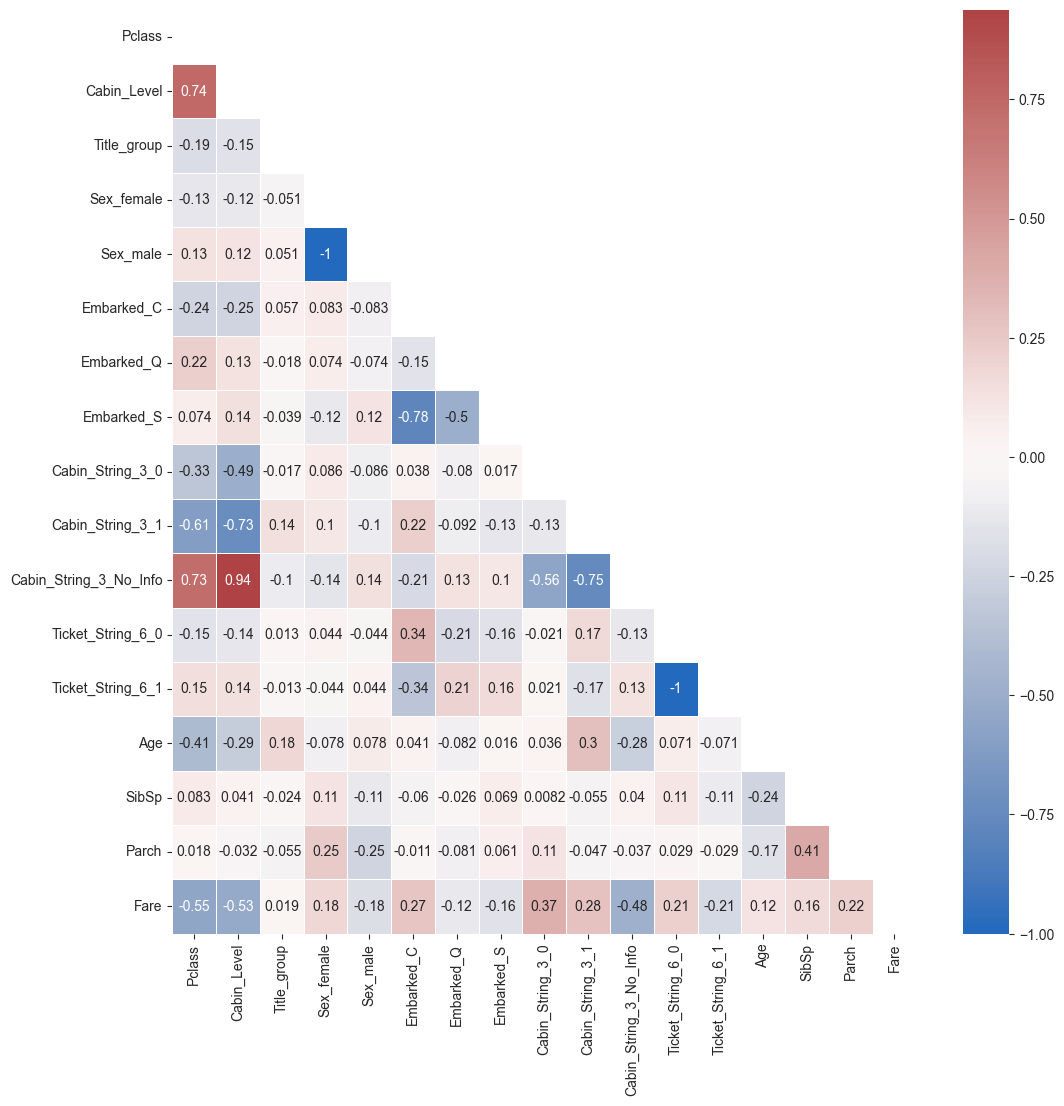

In [109]:
# Prüfe Multikollinearität
df_correlation_matrix = X_train_df.corr(method='pearson')
# Triangle 
matrix = np.triu(df_correlation_matrix)

# Plotting der matrix
plt.figure(figsize=(12, 12))
sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df_correlation_matrix, annot=True, mask=matrix, cmap="vlag", center=0, linewidths=0.5)
plt.show()


In [110]:
## VIF prüfen

X_train_df_tmp = X_train_df.copy()
print(f"Before X_train_df_tmp: {X_train_df_tmp.shape}")
X_train_df_tmp = remove_nominal_feature_value(X_train_df_tmp, nominal_cols)
cols_tmp = X_train_df_tmp.columns.tolist()
print(f"After X_train_df_tmp: {X_train_df_tmp.shape}")

# Calculate VIF for each feature
vif_combined = pd.DataFrame()
vif_combined["Feature"] = cols_tmp
vif_combined["VIF"] = [variance_inflation_factor(X_train_df_tmp.values, i) for i in range(X_train_df_tmp.shape[1])]

vif_combined

Before X_train_df_tmp: (891, 17)
For Sex - removed: Sex_female
For Embarked - removed: Embarked_C
For Cabin_String_3 - removed: Cabin_String_3_0
For Ticket_String_6 - removed: Ticket_String_6_0
After X_train_df_tmp: (891, 13)


,Feature,VIF
0,Pclass,9.876420
1,Cabin_Level,59.606962
2,Title_group,1.105837
3,Sex_male,3.123186
4,Embarked_Q,1.795068
5,Embarked_S,5.715656
6,Cabin_String_3_1,2.225614
7,Cabin_String_3_No_Info,39.304738
8,Ticket_String_6_1,2.228759
9,Age,6.417140


In [111]:
## Cabin_Level und Cabin_String_3 haben hohe VIF Werte, daher entfernen von Cabin_String_3-Features

cabin_string_3_cols = [col for col in X_train_df.columns if 'Cabin_String_3' in col]
cabin_string_3_cols


['Cabin_String_3_0', 'Cabin_String_3_1', 'Cabin_String_3_No_Info']

In [112]:
print(f"X_train_df: {X_train_df.shape}, X_test_df: {X_test_df.shape}")
for col in cabin_string_3_cols:
    del X_train_df[col]
    del X_test_df[col]
print(f"X_train_df: {X_train_df.shape}, X_test_df: {X_test_df.shape}")

X_train_df: (891, 17), X_test_df: (418, 17)
X_train_df: (891, 14), X_test_df: (418, 14)


In [113]:
nominal_cols_2 = ['Sex', 'Embarked', 'Ticket_String_6'] # ohne 'Cabin_String_3'

In [114]:
print_VIF(X_train_df, nominal_cols_2)

              Feature        VIF
0              Pclass   9.796867
1         Cabin_Level  16.022416
2         Title_group   1.088986
3            Sex_male   3.105839
4          Embarked_Q   1.771889
5          Embarked_S   5.529905
6   Ticket_String_6_1   2.223757
7                 Age   5.161824
8               SibSp   1.607593
9               Parch   1.625344
10               Fare   1.829342


In [115]:
## Cabin_Level weiterhin hohe VIF Werte, daher entfernen 
print(f"X_train_df: {X_train_df.shape}, X_test_df: {X_test_df.shape}")
del X_train_df["Cabin_Level"]
del X_test_df["Cabin_Level"]
print(f"X_train_df: {X_train_df.shape}, X_test_df: {X_test_df.shape}")

X_train_df: (891, 14), X_test_df: (418, 14)
X_train_df: (891, 13), X_test_df: (418, 13)


In [116]:
print_VIF(X_train_df, nominal_cols_2)

             Feature       VIF
0             Pclass  4.072723
1        Title_group  1.088986
2           Sex_male  3.074635
3         Embarked_Q  1.760012
4         Embarked_S  5.215462
5  Ticket_String_6_1  2.213840
6                Age  4.344681
7              SibSp  1.602091
8              Parch  1.625069
9               Fare  1.808296


In [117]:
### Nach Entfernung der Cabin Saplten sind die VIF Werte in Ordnung

## Modeling

### Baseline Model (Logistische Regression)

In [118]:
RANDOM_STATE = random_state

In [119]:
logreg = LogisticRegression(solver = 'newton-cholesky',
                            C = 1,
                            random_state = RANDOM_STATE)

logreg_fit = logreg.fit(X_train_df, y_train)

In [120]:
y_pred_lr= logreg_fit.predict(X_test_df)

In [171]:
coef_df = get_model_coef_df(logreg_fit, X_train_df)
coef_df

Intercept: [2.29871307]
Coefficients:


,Feature,Coefficient
0,Pclass,-1.105002
1,Title_group,-0.022577
2,Sex_female,1.313337
3,Sex_male,-1.313337
4,Embarked_C,0.041847
5,Embarked_Q,0.188542
6,Embarked_S,-0.230389
7,Ticket_String_6_0,0.222487
8,Ticket_String_6_1,-0.222487
9,Age,-2.384588


#### Performance untersuchen

In [122]:
get_accuracy_score(logreg_fit, X_train_df, X_test_df, y_train, y_test)


Training Accurarcy: 0.8025
Testing Accuracy: 0.9402
Train-Test Gap   : 0.1377


(0.8025, 0.9402, 0.1377)

In [123]:
get_cm_score(y_test = y_test, y_pred_test = y_pred_lr)


    
True Negatives : 251
    False Positives: 15
    False Negatives: 10
    True Positives : 142
    


array([[251,  15],
       [ 10, 142]], dtype=int64)

In [172]:
print("\nClassification Report Logistic Regression (Training):")
print(classification_report(y_train, logreg_fit.predict(X_train_df)))

print("\nClassification Report Logistic Regression (Testing):")
print(classification_report(y_test, y_pred_lr))


Classification Report Logistic Regression (Training):
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       549
           1       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891


Classification Report Logistic Regression (Testing):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       266
           1       0.90      0.93      0.92       152

    accuracy                           0.94       418
   macro avg       0.93      0.94      0.94       418
weighted avg       0.94      0.94      0.94       418



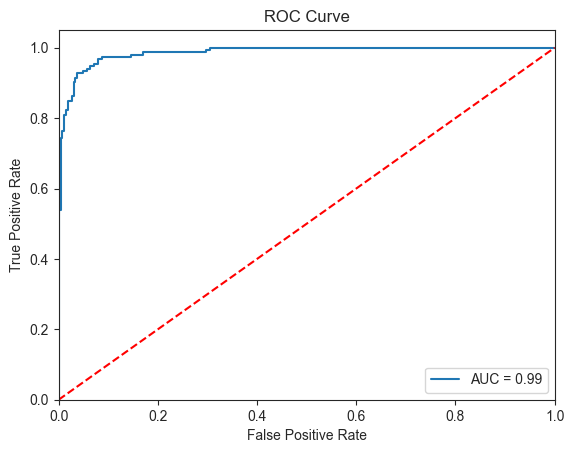

AUC: 0.9861743173723783


In [125]:
auc_lr = get_roc_score(logreg_fit, X_test_df, y_test)
print(f"AUC: {auc_lr}")

In [126]:
save_model(logreg_fit, "logreg_baseline", model_path)

Model saved as models/logreg_baseline.joblib


In [180]:
result_df = pd.DataFrame({'PassengerId': ids_test, 
                          'Survived': y_pred_lr, 
                          'Survived_Prob': logreg_fit.predict_proba(X_test_df)[:,1]})
result_df.shape

(418, 3)

In [181]:
df_merged = df_test.merge(result_df, on='PassengerId', how='left')
df_merged.shape

(418, 13)

In [182]:
df_merged.head(n=5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Survived_Prob
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.093102
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.344082
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.119777
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.077976
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.618957


In [183]:
df_merged.to_csv(output_data_path+'logreg_predictions.csv', index=False)

In [189]:
csv_file_path = output_data_path+"logreg_predictions.csv"
df_tmp_pred = pd.read_csv(csv_file_path)
print(df_tmp_pred.shape)
df_tmp_pred.head(n=5)


(418, 13)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Survived_Prob
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0.093102
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0.344082
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0.119777
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0.077976
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,0.618957


#### Shap Werte für LR-Modell interpretieren

In [127]:
shap_explainer = get_shap_explainer(logreg_fit, X_train_df, model_type='logreg') #shap.Explainer(logreg_fit, X_train_df)

In [128]:
shap_values = shap_explainer(X_test_df)

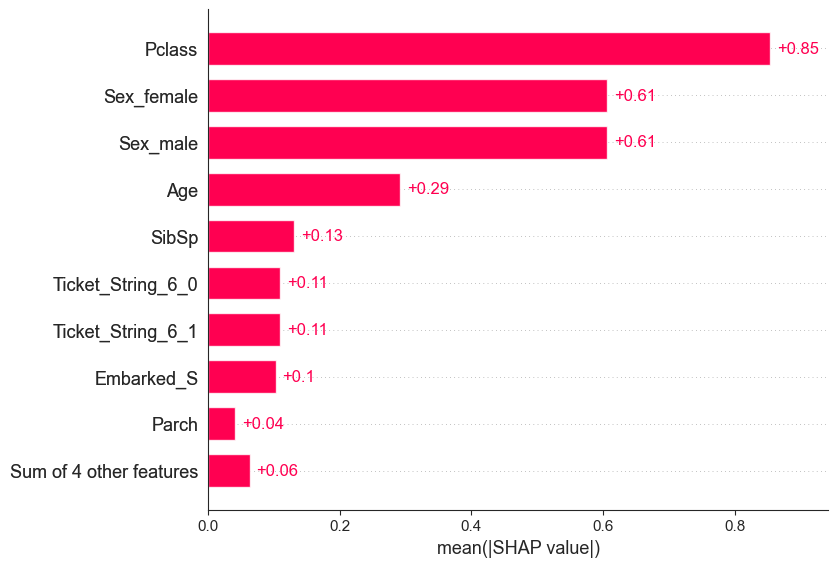

<Figure size 640x480 with 0 Axes>

In [129]:
# Importance der features
shap.plots.bar(shap_values)
plt.savefig(plot_path+'LogisticRegression_Shap_FeatureImportance.png', dpi=300, bbox_inches='tight')

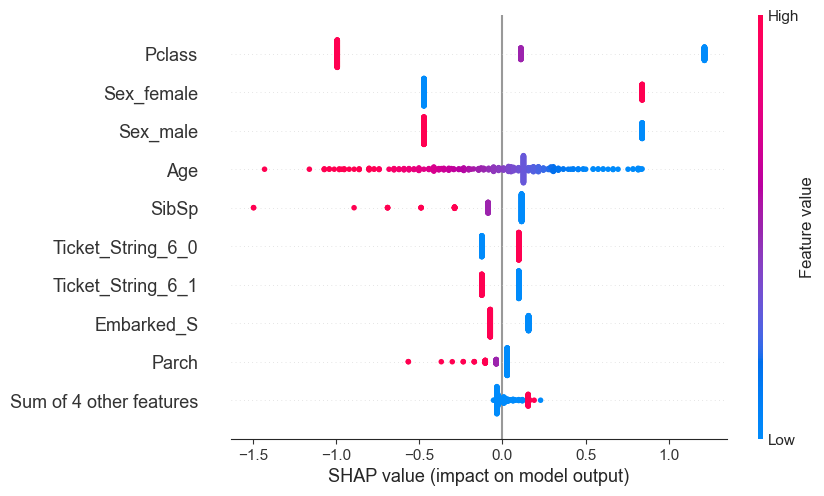

<Figure size 640x480 with 0 Axes>

In [130]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)
plt.savefig(plot_path+'LogisticRegression_Shap_Beeswarm.png', dpi=300, bbox_inches='tight')

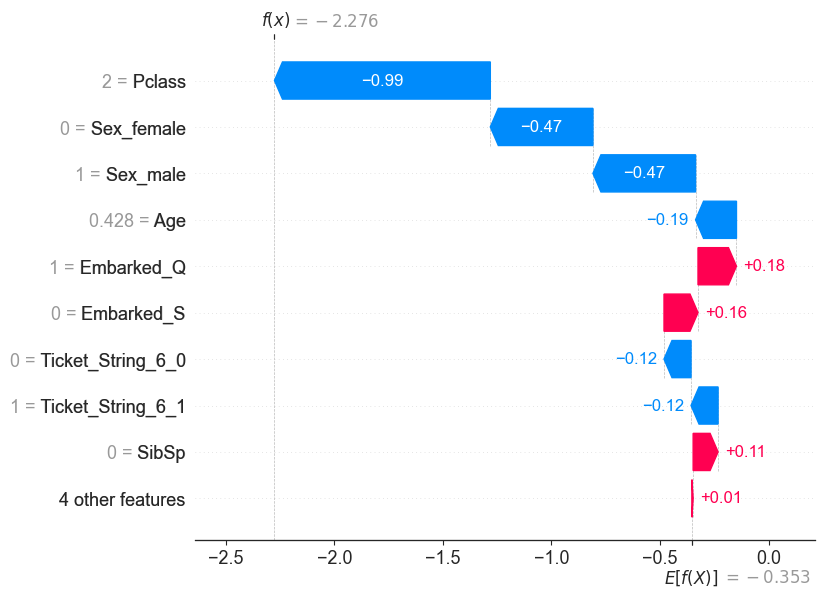

In [131]:
shap.plots.waterfall(shap_values[0])

In [132]:
## Shap Values für einzelne Passagiere

In [133]:
X_test.head(n=5)

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked,Title_group,Cabin_Level,Cabin_String_3,Ticket_String_6
0,34.5,0,0,7.8292,3,male,Q,Civilian,No_Info,No_Info,1
1,47.0,1,0,7.0000,3,female,S,Civilian,No_Info,No_Info,1
2,62.0,0,0,9.6875,2,male,Q,Civilian,No_Info,No_Info,1
3,27.0,0,0,8.6625,3,male,S,Civilian,No_Info,No_Info,1
4,22.0,1,1,12.2875,3,female,S,Civilian,No_Info,No_Info,0


In [134]:
X_test_df.head(n=3)

,Pclass,Title_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_String_6_0,Ticket_String_6_1,Age,SibSp,Parch,Fare
0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.428248,0.000,0.0,0.015282
1,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.585323,0.125,0.0,0.013663
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.773813,0.000,0.0,0.018909


In [135]:
personas = {
    "manOld": X_test[X_test['Sex'] == 'male'].sort_values(by='Age', ascending=False).head(n=1).index,
    "manYoung": X_test[X_test['Sex'] == 'male'].sort_values(by='Age', ascending=True).head(n=1).index,
    "womanOld": X_test[X_test['Sex'] == 'female'].sort_values(by='Age', ascending=False).head(n=1).index,
    "womanYoung": X_test[X_test['Sex'] == 'female'].sort_values(by='Age', ascending=True).head(n=1).index,
    "manPC1": X_test[X_test['Sex'] == 'male'].sort_values(by='Pclass', ascending=True).head(n=1).index,
    "manPC3": X_test[X_test['Sex'] == 'male'].sort_values(by='Pclass', ascending=False).head(n=1).index,
    "womanPC1": X_test[X_test['Sex'] == 'female'].sort_values(by='Pclass', ascending=True).head(n=1).index,
    "womanPC3": X_test[X_test['Sex'] == 'female'].sort_values(by='Pclass', ascending=False).head(n=1).index
}

In [136]:
old_man_passenger = X_test_df.iloc[personas["manOld"]]
old_man_passenger

,Pclass,Title_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_String_6_0,Ticket_String_6_1,Age,SibSp,Parch,Fare
81,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.836642,0.125,0.0,0.432884


In [137]:
old_woman_passenger = X_test_df.iloc[personas["womanOld"]]
old_woman_passenger

,Pclass,Title_group,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Ticket_String_6_0,Ticket_String_6_1,Age,SibSp,Parch,Fare
96,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.949736,0.125,0.0,0.153905


manOld
y_true: [0], y_pred: [0]
     Age  SibSp  Parch      Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
81  67.0      1      0  221.7792      1  male        S    Civilian           C              0               0


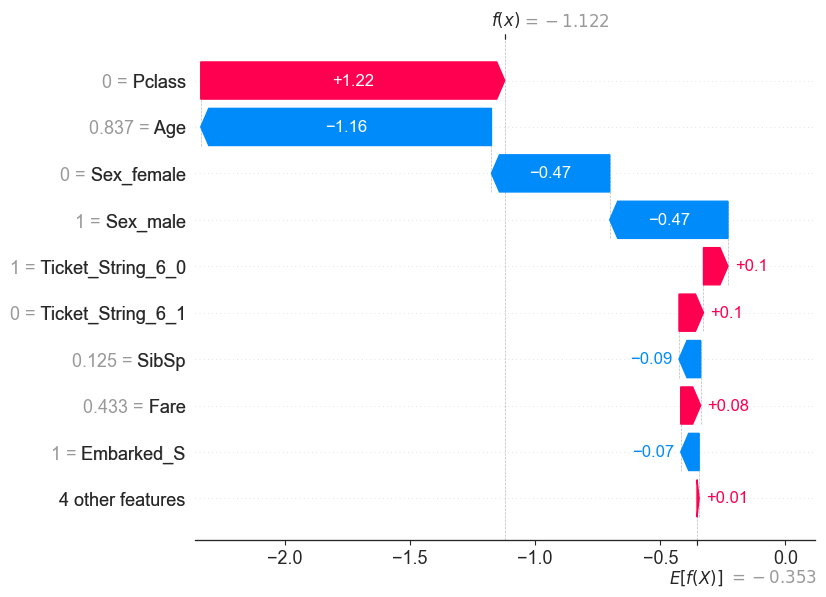

manYoung
y_true: [0], y_pred: [0]
      Age  SibSp  Parch  Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
201  0.33      0      2  14.4      3  male        S    Civilian     No_Info        No_Info               1


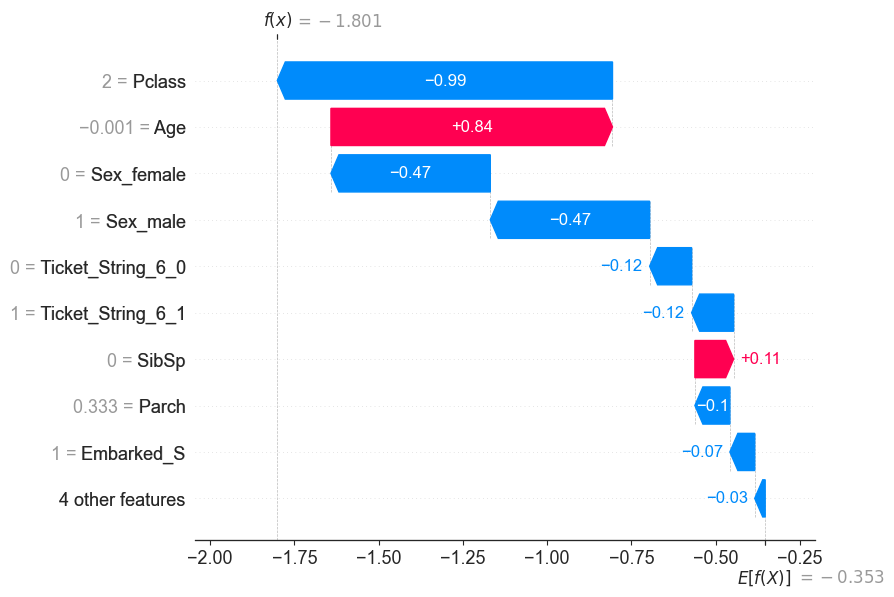

womanOld
y_true: [1], y_pred: [1]
     Age  SibSp  Parch   Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
96  76.0      1      0  78.85      1  female        S    Civilian           C              1               0


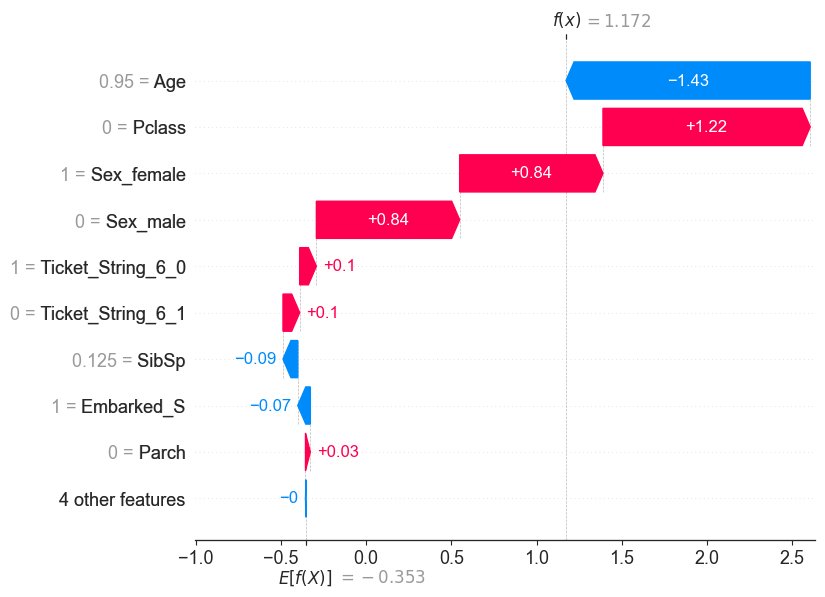

womanYoung
y_true: [1], y_pred: [1]
      Age  SibSp  Parch    Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
354  0.17      1      2  20.575      3  female        S    Civilian     No_Info        No_Info               0


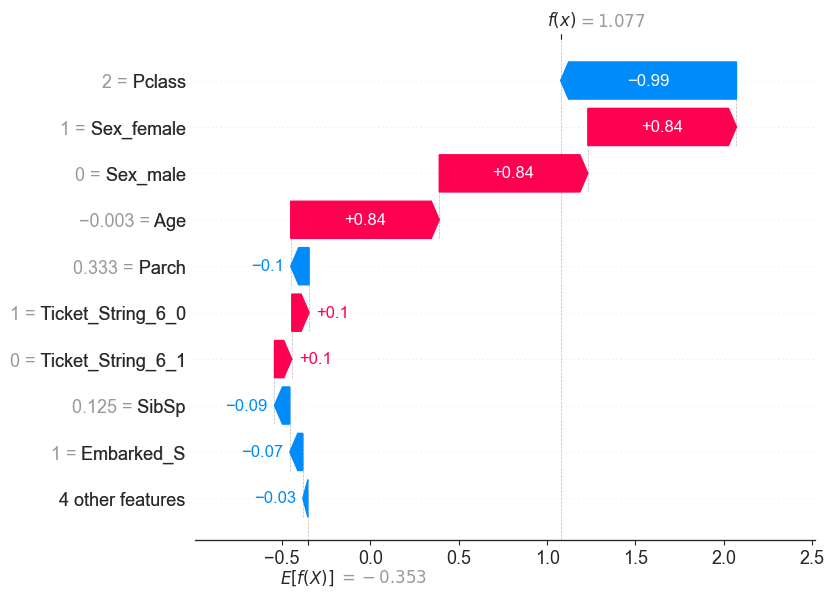

manPC1
y_true: [0], y_pred: [0]
      Age  SibSp  Parch  Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
335  30.0      0      0  26.0      1  male        S    Civilian           C              0               1


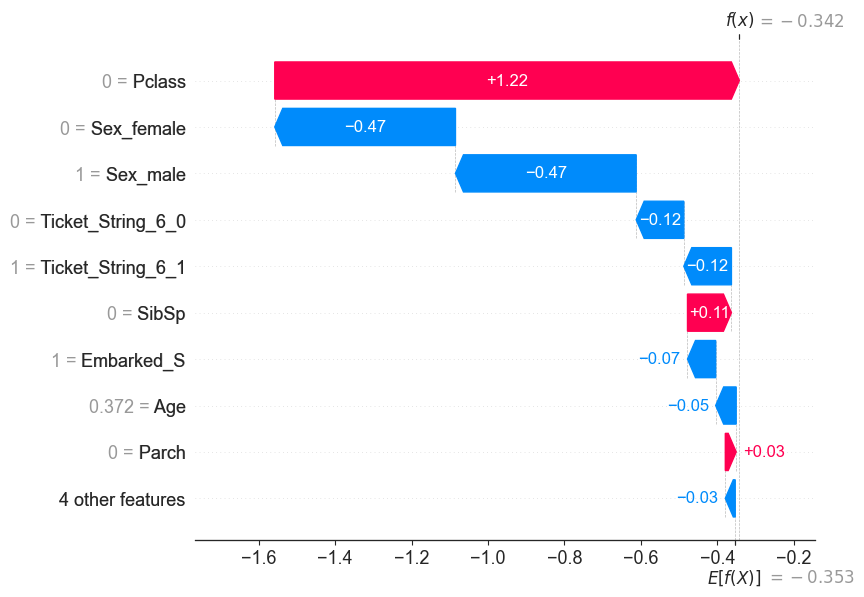

manPC3
y_true: [0], y_pred: [0]
    Age  SibSp  Parch    Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
0  34.5      0      0  7.8292      3  male        Q    Civilian     No_Info        No_Info               1


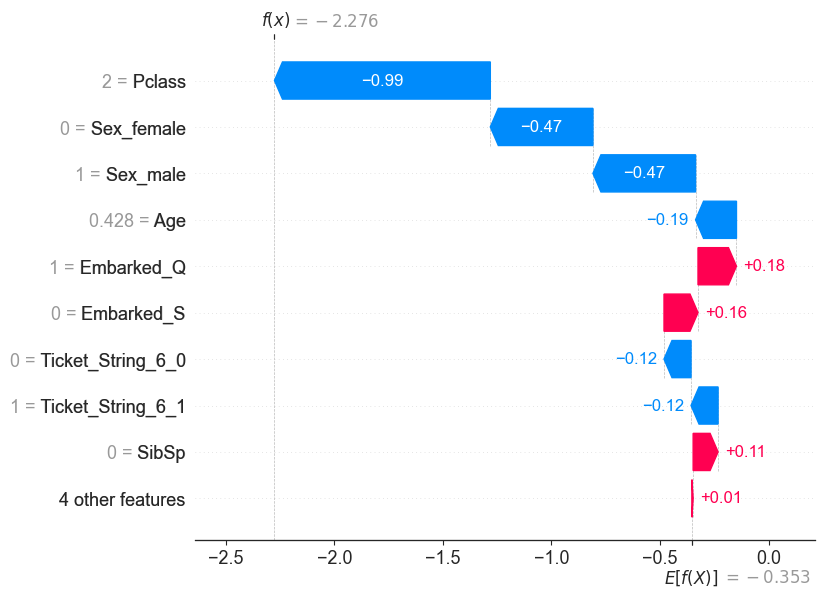

womanPC1
y_true: [1], y_pred: [1]
      Age  SibSp  Parch   Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
414  39.0      0      0  108.9      1  female        C       Noble           C              0               0


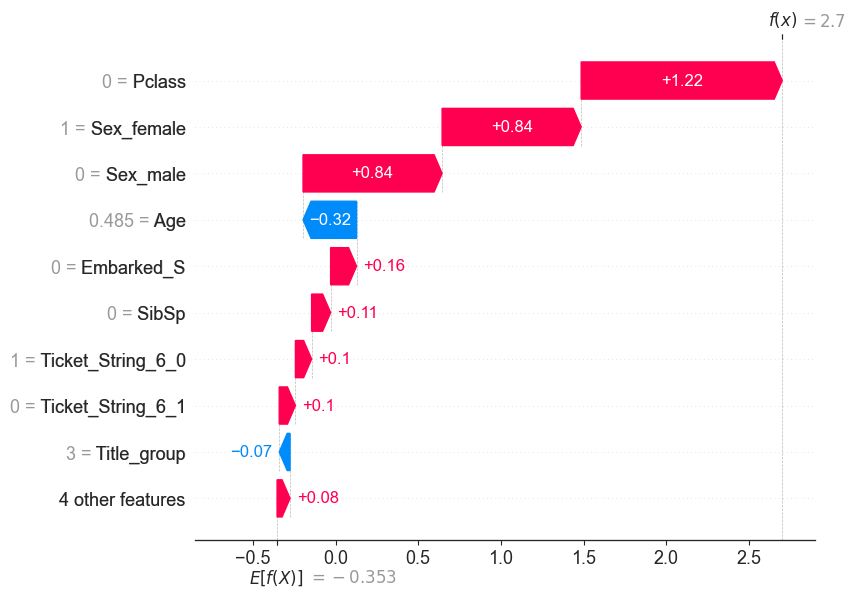

womanPC3
y_true: [1], y_pred: [0]
    Age  SibSp  Parch  Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
1  47.0      1      0   7.0      3  female        S    Civilian     No_Info        No_Info               1


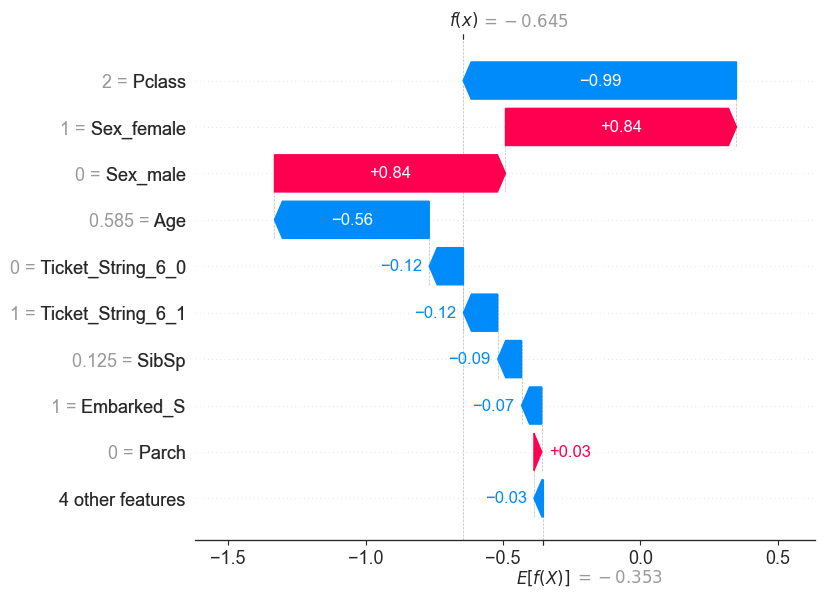

In [138]:
for persona in personas:

    i_tmp = personas[persona]
    X_tmp = X_test_df.iloc[i_tmp]
    y_tmp = y_test[i_tmp]
    y_pred = logreg_fit.predict(X_tmp)
    print(persona)
    print(f"y_true: {y_tmp}, y_pred: {y_pred}")
    print(X_test.iloc[i_tmp])
    plot_shap_waterfall_single(shap_explainer, X_tmp)

### Random Forrest Classifier

In [139]:
param_dist = {
    'n_estimators': sp_randint(2, 101), 
    'max_depth': sp_randint(2, 21),   
    'min_samples_split': sp_randint(2, 21), 
    'min_samples_leaf': sp_randint(2, 21), 
    'max_features': ['sqrt', 'log2', None]  
}

In [140]:
rfc = RandomForestClassifier()

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) # weil y nicht 50/50 verteilt

random_search_cv = RandomizedSearchCV(
    rfc, 
    param_distributions=param_dist, 
    n_iter=200, 
    cv=stratified_cv, 
    verbose=1, 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

In [141]:
random_search_cv.fit(X_train_df, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=91, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=200, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023DC8E0B150>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023DC8C76490>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023DC9313750>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000023DC8BAA1D0>},
                   random_state=91, verbose=1)

In [142]:
print("Best score:", random_search_cv.best_score_)

Best score: 0.8316740945326722


In [143]:
print("Best Parameters:", random_search_cv.best_params_)
best_rfc = random_search_cv.best_estimator_

Best Parameters: {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 59}


In [144]:
y_pred_rfc_train = best_rfc.predict(X_train_df)
print("Train Accuracy:", accuracy_score(y_train, y_pred_rfc_train))

Train Accuracy: 0.9292929292929293


In [145]:
y_pred_rfc = best_rfc.predict(X_test_df)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rfc))

Test Accuracy: 0.8732057416267942


In [146]:
save_model(best_rfc, "best_rfc", model_path)

Model saved as models/best_rfc.joblib


Best Parameters: {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 59}


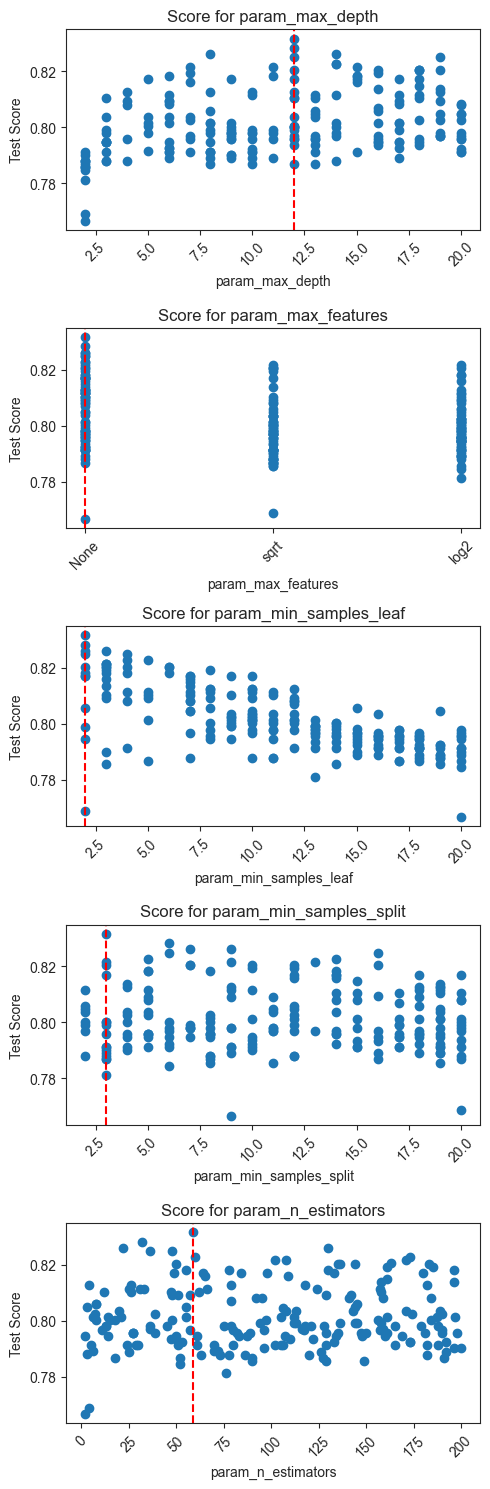

(200, 18)


In [147]:
# Convert cv_results_ to a DataFrame
cv_results_df = get_cv_param_scoring(random_search_cv) #pd.DataFrame(random_search_cv.cv_results_)
print(cv_results_df.shape)

In [148]:
cv_results_df.to_csv(output_data_path+'rfc_cv_results_df.csv', sep=";", encoding='utf-8', index=False)

In [149]:
cv_results_df.sort_values(by='rank_test_score').head(n=5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
49,0.135931,0.005820,0.009820,0.007147,12,None,2,3,59,"{'max_depth': 12, 'max_features': None, 'min_s...",0.810056,0.870787,0.825843,0.808989,0.842697,0.831674,0.023097,1
53,0.081700,0.010485,0.004201,0.000403,12,None,2,6,32,"{'max_depth': 12, 'max_features': None, 'min_s...",0.804469,0.870787,0.820225,0.786517,0.859551,0.828310,0.032127,2
43,0.293177,0.017644,0.010618,0.000803,14,None,3,9,130,"{'max_depth': 14, 'max_features': None, 'min_s...",0.798883,0.865169,0.820225,0.786517,0.859551,0.826069,0.031583,3
61,0.052377,0.006335,0.003503,0.000447,8,None,2,7,22,"{'max_depth': 8, 'max_features': None, 'min_sa...",0.798883,0.870787,0.825843,0.797753,0.837079,0.826069,0.027062,4
99,0.105129,0.003417,0.005977,0.001571,12,None,4,6,48,"{'max_depth': 12, 'max_features': None, 'min_s...",0.793296,0.853933,0.820225,0.803371,0.853933,0.824951,0.025179,5


#### Performance untersuchen

In [151]:
get_accuracy_score(best_rfc, X_train_df, X_test_df, y_train, y_test)


Training Accurarcy: 0.9293
Testing Accuracy: 0.8732
Train-Test Gap   : 0.0561


(0.9293, 0.8732, 0.0561)

In [152]:
get_cm_score(y_test, y_pred_rfc)


    
True Negatives : 247
    False Positives: 19
    False Negatives: 34
    True Positives : 118
    


array([[247,  19],
       [ 34, 118]], dtype=int64)

In [175]:
#_ = get_cr_score(y_test, y_pred_rfc)

print("\nClassification Report Random Forest Classifier (Training):")
print(classification_report(y_train, best_rfc.predict(X_train_df)))

print("\nClassification Report Random Forest Classifier (Testing):")
print(classification_report(y_test, y_pred_rfc))


Classification Report Random Forest Classifier (Training):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       549
           1       0.94      0.87      0.90       342

    accuracy                           0.93       891
   macro avg       0.93      0.92      0.92       891
weighted avg       0.93      0.93      0.93       891


Classification Report Random Forest Classifier (Testing):
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       266
           1       0.86      0.78      0.82       152

    accuracy                           0.87       418
   macro avg       0.87      0.85      0.86       418
weighted avg       0.87      0.87      0.87       418



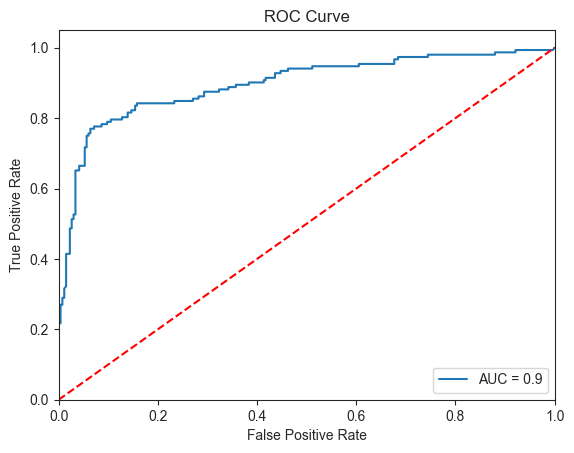

AUC: 0.8959240205777601


In [154]:
auc_rfc = get_roc_score(best_rfc, X_test_df, y_test)
print(f"AUC: {auc_rfc}")

In [155]:
len(best_rfc.estimators_) # Anzahl der Bäume im besten Modell

59

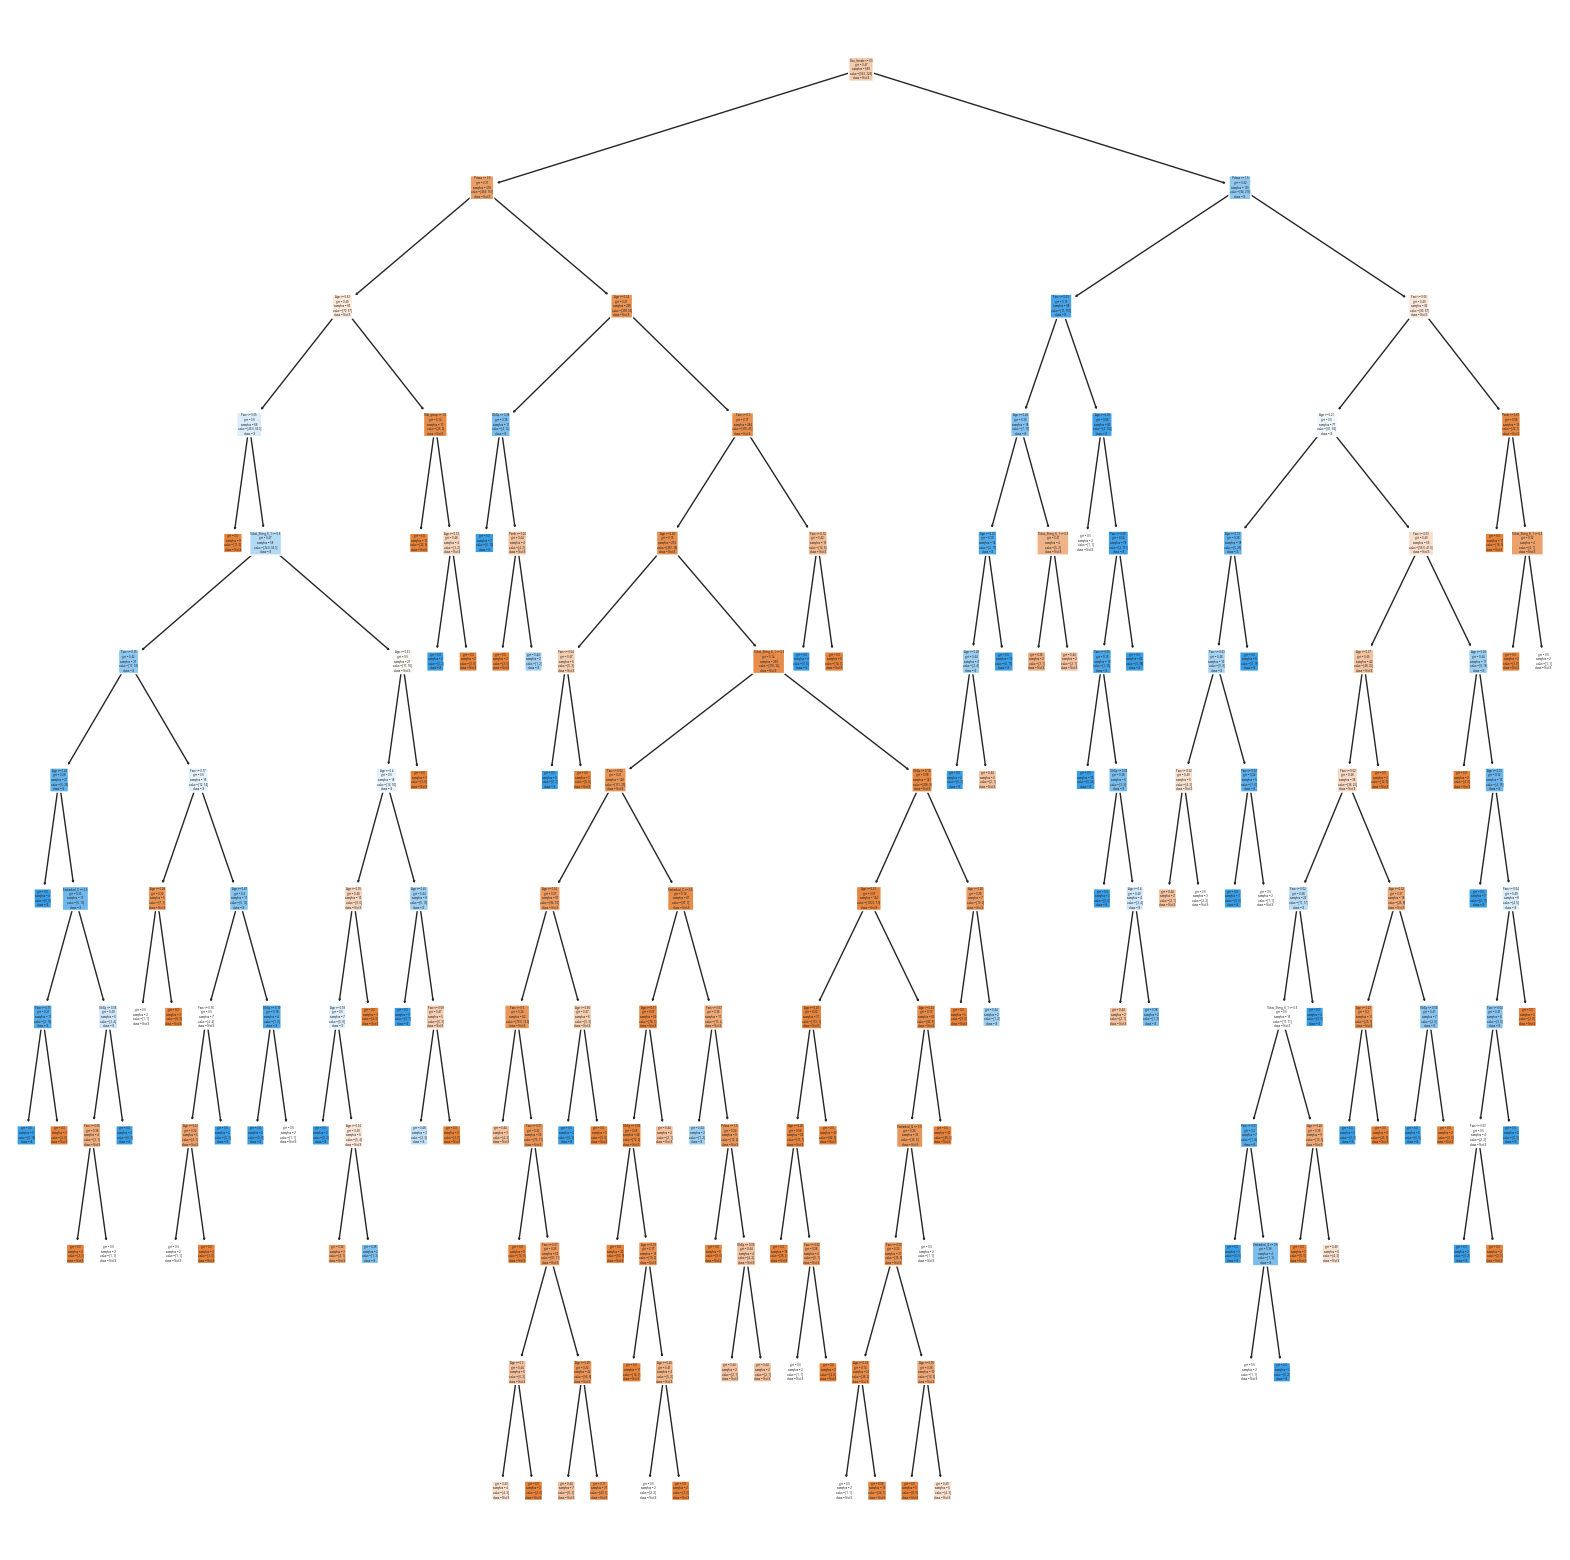

<module 'matplotlib.pyplot' from 'c:\\Users\\Awet\\anaconda3\\envs\\DataScience_Standard\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [156]:
plot_decision_tree(best_rfc, 0, X_test_df.columns.tolist(), ["Not S", "S"]) # Plot des ersten Baumes

#### Threshold Analyse

In [157]:
y_prob = best_rfc.predict_proba(X_test_df)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.8959240205777601


In [158]:
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")

Optimal Threshold: 0.5365751950497714


In [159]:
y_pred_rfc_ct = (y_prob > optimal_threshold).astype(int)

In [160]:
get_cm_score(y_test, y_pred_rfc)


    
True Negatives : 247
    False Positives: 19
    False Negatives: 34
    True Positives : 118
    


array([[247,  19],
       [ 34, 118]], dtype=int64)

In [161]:
get_cm_score(y_test, y_pred_rfc_ct) 


    
True Negatives : 249
    False Positives: 17
    False Negatives: 36
    True Positives : 116
    


array([[249,  17],
       [ 36, 116]], dtype=int64)

In [162]:
_ = get_cr_score(y_test, y_pred_rfc)


Classification Report
              precision  recall  f1-score  support
0                  0.88    0.93      0.90   266.00
1                  0.86    0.78      0.82   152.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.87    0.85      0.86   418.00
weighted avg       0.87    0.87      0.87   418.00


In [163]:
_ = get_cr_score(y_test, y_pred_rfc_ct)


Classification Report
              precision  recall  f1-score  support
0                  0.87    0.94      0.90   266.00
1                  0.87    0.76      0.81   152.00
accuracy           0.87    0.87      0.87     0.87
macro avg          0.87    0.85      0.86   418.00
weighted avg       0.87    0.87      0.87   418.00


#### Shap Werte RFC

In [164]:
shap_explainer_rfc = get_shap_explainer(best_rfc, X_train_df, model_type='rfc')

In [165]:
shap_values = shap_explainer_rfc(X_test_df)
shap_values_positive_class = shap_values[..., 1]

print(f"shap_values: {shap_values.shape}, shap_values_positive_class: {shap_values_positive_class.shape}")

shap_values: (418, 13, 2), shap_values_positive_class: (418, 13)


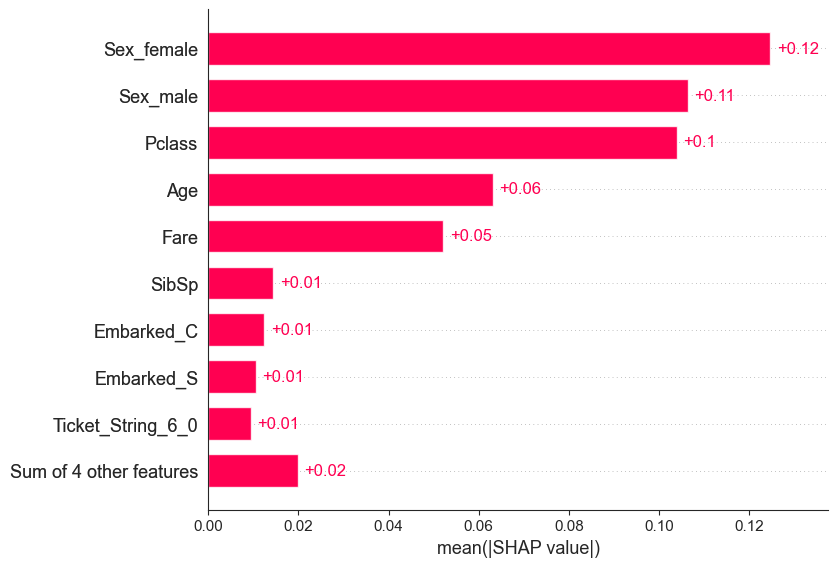

<Figure size 640x480 with 0 Axes>

In [166]:
get_shap_importance(shap_values_positive_class)
plt.savefig(plot_path+'RandomForestClassifier_Shap_FeatureImportance.png', dpi=300, bbox_inches='tight')

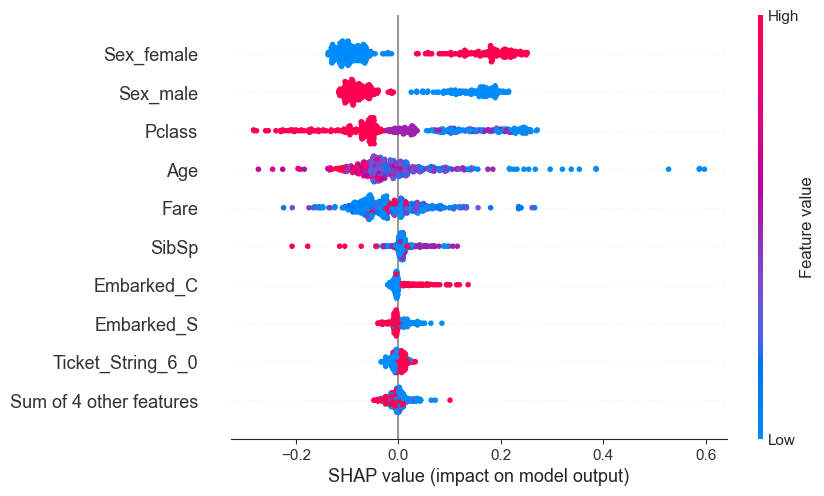

<Figure size 640x480 with 0 Axes>

In [167]:
get_shap_beeswarm(shap_values_positive_class)
plt.savefig(plot_path+'RandomForestClassifier_Shap_Beeswarm.png', dpi=300, bbox_inches='tight')

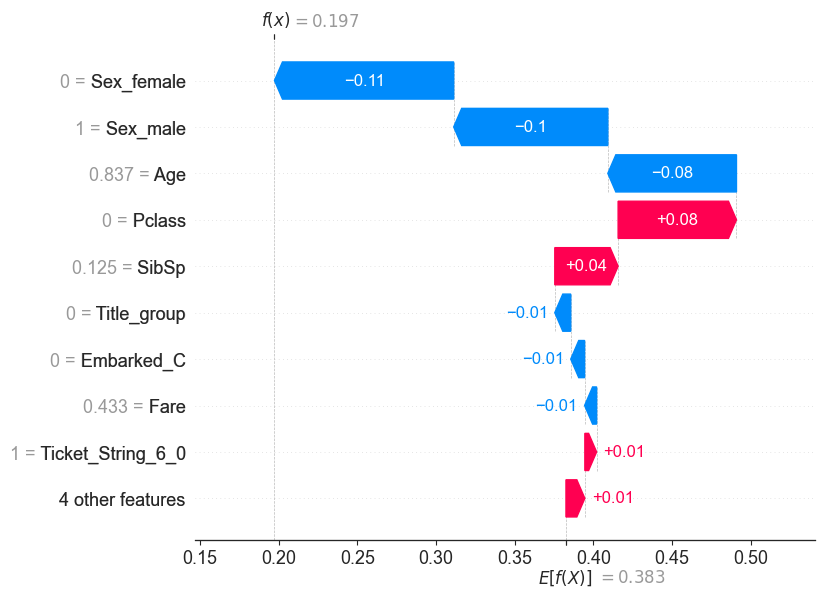

In [168]:
i_tmp = personas['manOld']
X_tmp = X_test_df.iloc[i_tmp]

get_shap_waterfall_single(shap_values_positive_class, X_tmp)

In [169]:
personas

{'manOld': Index([81], dtype='int64'),
 'manYoung': Index([201], dtype='int64'),
 'womanOld': Index([96], dtype='int64'),
 'womanYoung': Index([354], dtype='int64'),
 'manPC1': Index([335], dtype='int64'),
 'manPC3': Index([0], dtype='int64'),
 'womanPC1': Index([414], dtype='int64'),
 'womanPC3': Index([1], dtype='int64')}

manOld
y_true: [0], y_pred: [0], y_pred_rfc_ct: [0]
     Age  SibSp  Parch      Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
81  67.0      1      0  221.7792      1  male        S    Civilian           C              0               0


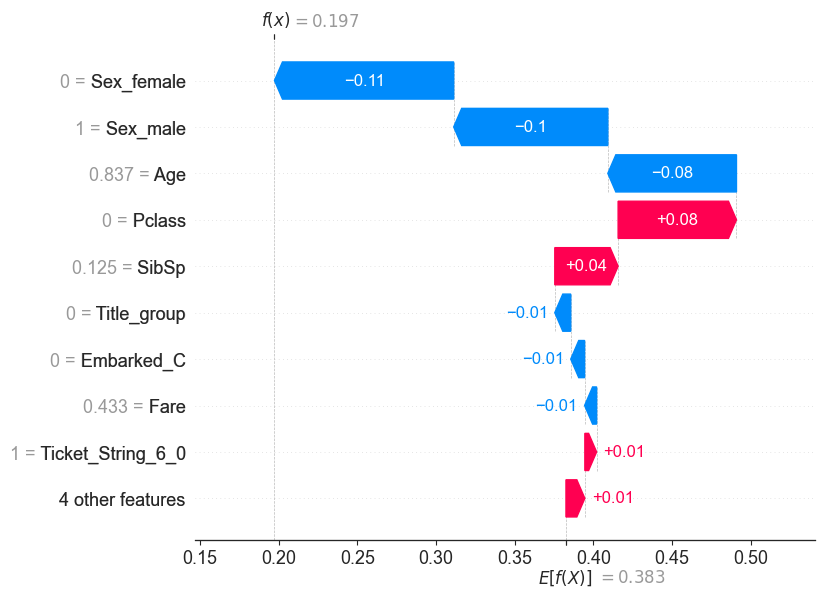

manYoung
y_true: [0], y_pred: [1], y_pred_rfc_ct: [1]
      Age  SibSp  Parch  Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
201  0.33      0      2  14.4      3  male        S    Civilian     No_Info        No_Info               1


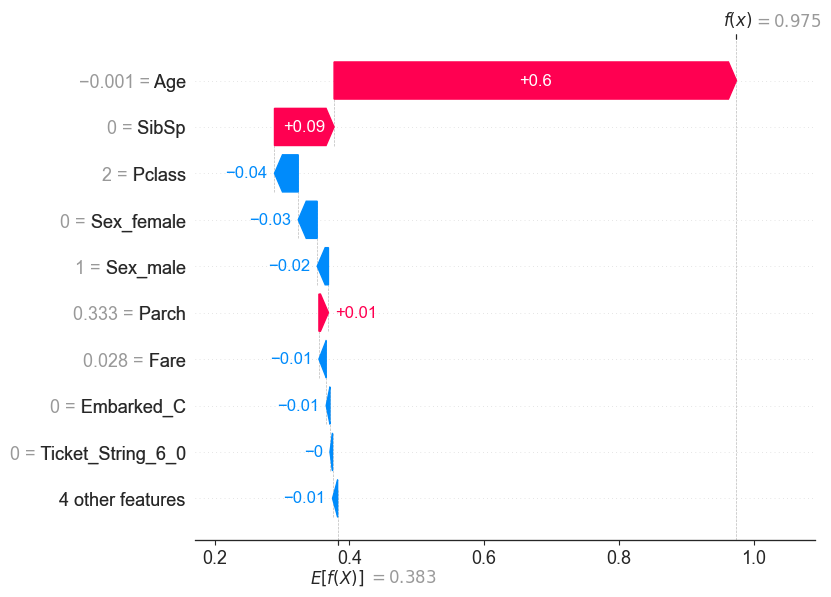

womanOld
y_true: [1], y_pred: [1], y_pred_rfc_ct: [1]
     Age  SibSp  Parch   Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
96  76.0      1      0  78.85      1  female        S    Civilian           C              1               0


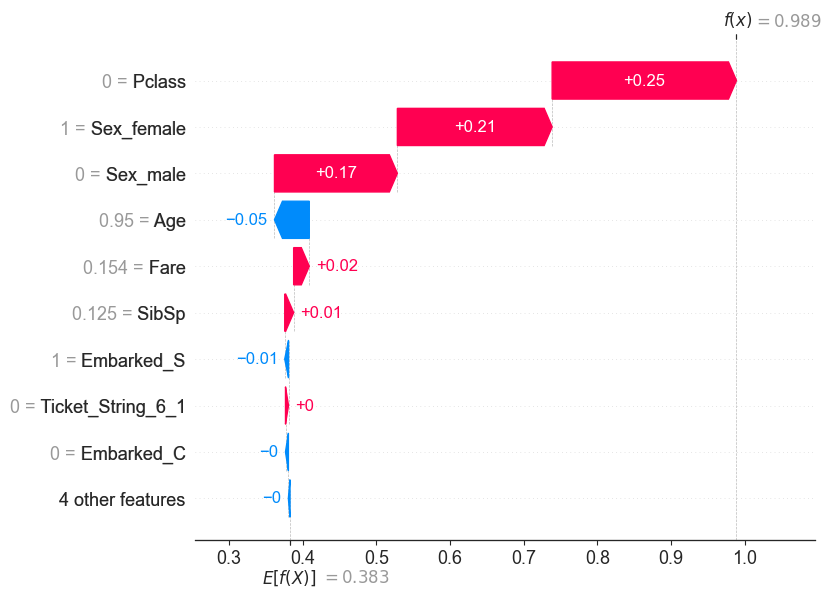

womanYoung
y_true: [1], y_pred: [1], y_pred_rfc_ct: [1]
      Age  SibSp  Parch    Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
354  0.17      1      2  20.575      3  female        S    Civilian     No_Info        No_Info               0


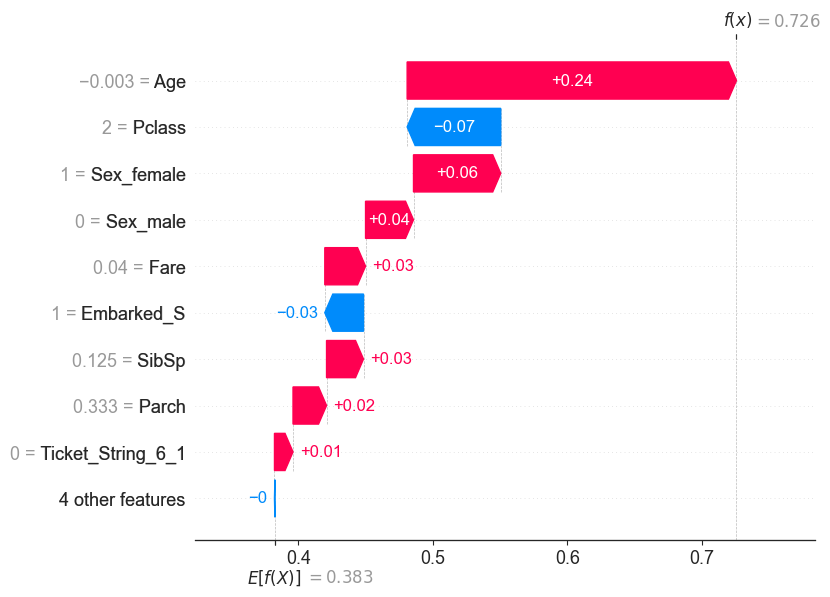

manPC1
y_true: [0], y_pred: [0], y_pred_rfc_ct: [0]
      Age  SibSp  Parch  Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
335  30.0      0      0  26.0      1  male        S    Civilian           C              0               1


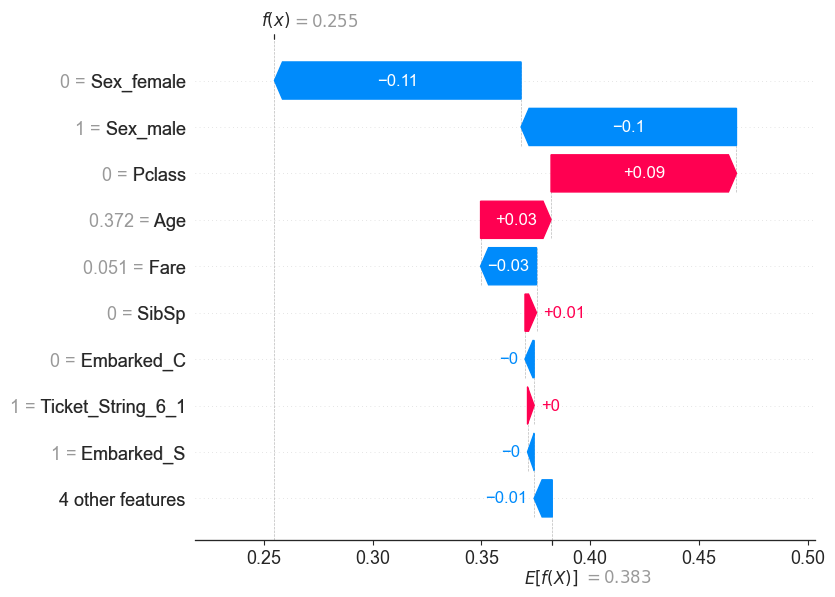

manPC3
y_true: [0], y_pred: [0], y_pred_rfc_ct: [0]
    Age  SibSp  Parch    Fare Pclass   Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
0  34.5      0      0  7.8292      3  male        Q    Civilian     No_Info        No_Info               1


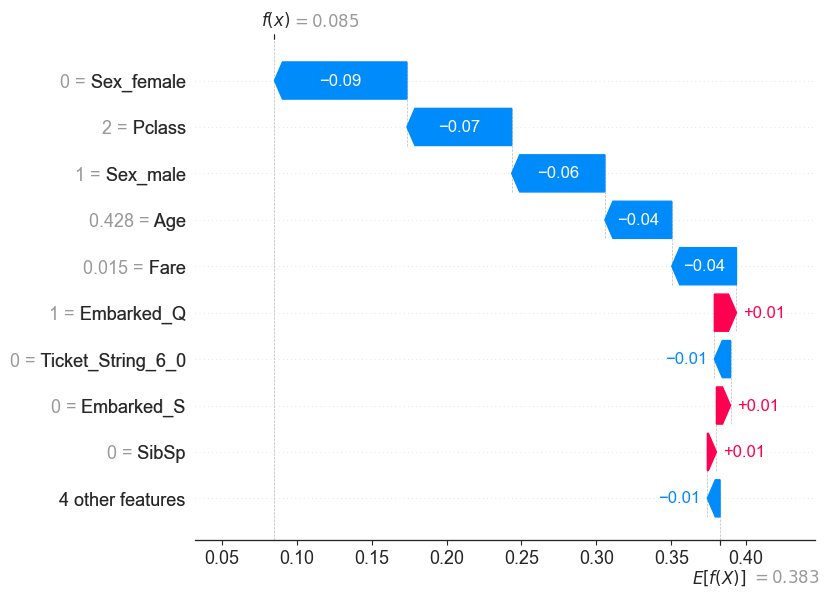

womanPC1
y_true: [1], y_pred: [1], y_pred_rfc_ct: [1]
      Age  SibSp  Parch   Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
414  39.0      0      0  108.9      1  female        C       Noble           C              0               0


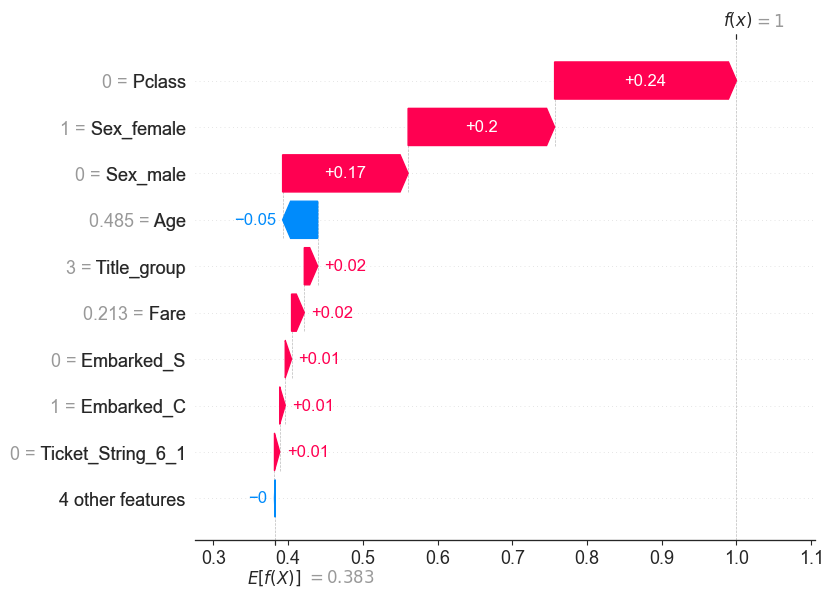

womanPC3
y_true: [1], y_pred: [0], y_pred_rfc_ct: [0]
    Age  SibSp  Parch  Fare Pclass     Sex Embarked Title_group Cabin_Level Cabin_String_3 Ticket_String_6
1  47.0      1      0   7.0      3  female        S    Civilian     No_Info        No_Info               1


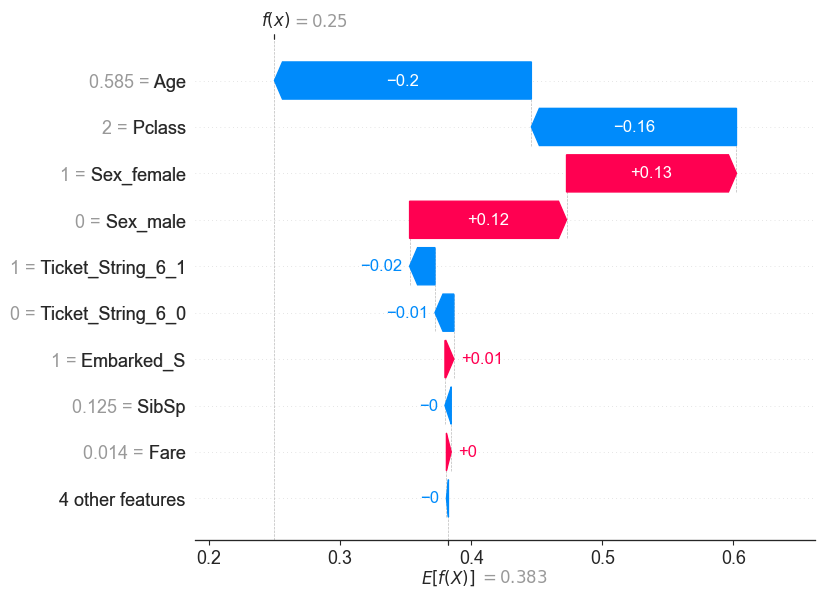

In [170]:
for persona in personas:

    i_tmp = personas[persona]
    X_tmp = X_test_df.iloc[i_tmp]

    shap_values_instance = shap_values_positive_class.values[i_tmp, :]  # For class 1
    expected_value_class = shap_explainer_rfc.expected_value[1]

    y_tmp = y_test[i_tmp]
    y_pred = best_rfc.predict(X_tmp)
    y_pred_rfc_ct = (best_rfc.predict_proba(X_tmp)[:, 1] > optimal_threshold).astype(int)

    print(persona)
    print(f"y_true: {y_tmp}, y_pred: {y_pred}, y_pred_rfc_ct: {y_pred_rfc_ct}")
    print(X_test.iloc[i_tmp])

    get_shap_waterfall_single(shap_values_positive_class, X_tmp)

## Fazit

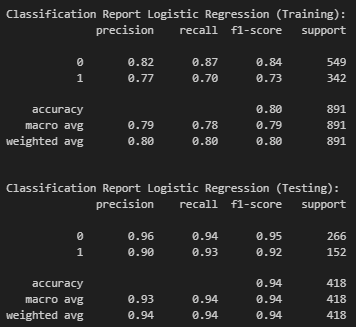 | 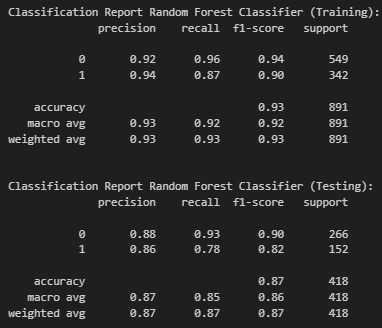

Die Performance vom Baseline Model (Logistische Regression) ist besser als die das hyperparamter optimierten Random Forest Models.


Anzumerken ist, dass das LR-Model beim Test-Set deutlich besser performt, als beim Training.
* Ursache ist hier kein Information Leakage im Datensatz, da das alternative RF-Model ein normales Verhalten ausweist.
* Anzunehmen ist, dass die Testdaten "einfacher" als die Trainingsdaten hervorgesagt werden können durch das LR-Model